In [1]:
%matplotlib inline
import os
import torch
import torchvision
from torch import nn
import torch
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision import models

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
from pathlib import Path
data_path = Path("/content/drive/My Drive/Datathon CBRE DSC/img/")
img_path = data_path / 'DSC Datathon IMG'

In [4]:
def walk_through_dir(dir_path):
  """Walks through dir_path, returning its contents"""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(img_path)

There are 5 directories and 456 images in '/content/drive/My Drive/Datathon CBRE DSC/img/DSC Datathon IMG'.
There are 0 directories and 73 images in '/content/drive/My Drive/Datathon CBRE DSC/img/DSC Datathon IMG/1'.
There are 0 directories and 71 images in '/content/drive/My Drive/Datathon CBRE DSC/img/DSC Datathon IMG/2'.
There are 0 directories and 16 images in '/content/drive/My Drive/Datathon CBRE DSC/img/DSC Datathon IMG/3'.
There are 0 directories and 17 images in '/content/drive/My Drive/Datathon CBRE DSC/img/DSC Datathon IMG/4'.
There are 0 directories and 48 images in '/content/drive/My Drive/Datathon CBRE DSC/img/DSC Datathon IMG/5'.


# 1. Training and testing dataset

/content/drive/My Drive/Datathon CBRE DSC/img/DSC Datathon IMG/1/1652924292_1.png
Random image path: /content/drive/My Drive/Datathon CBRE DSC/img/DSC Datathon IMG/1/1652924292_1.png
Image Class: 1
Image height: 854
Image width: 598


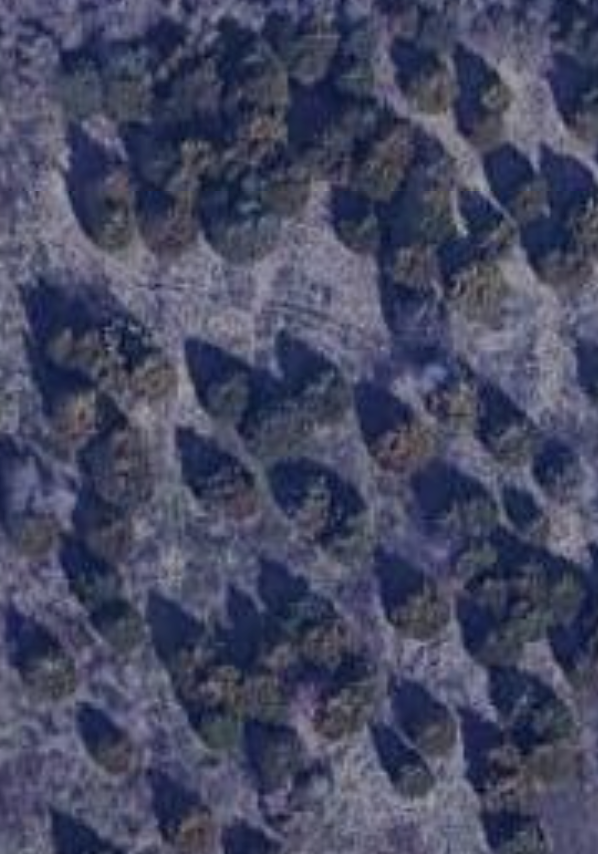

In [6]:
import random
from PIL import Image

img_path_list = list(img_path.glob("*/*.png"))


# 2. Pick a random image path
random_image_path = random.choice(img_path_list)
print(random_image_path)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem


# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image Class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

In [8]:
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torchvision import datasets
from sklearn.model_selection import train_test_split

dataset = datasets.ImageFolder(root=img_path)  # Initially without transformations

total_size = len(dataset)
train_size = int(0.8 * total_size)
remaining_size = total_size - train_size
validation_size = remaining_size // 2
test_size = remaining_size - validation_size

generator = torch.Generator().manual_seed(42)

train_dataset, remaining_dataset = random_split(dataset, [train_size, remaining_size], generator=generator)
validation_dataset, test_dataset = random_split(remaining_dataset, [validation_size, test_size], generator=generator)


In [9]:
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Crop a random portion of image and resize it to a given size.
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally.
    transforms.RandomVerticalFlip(p=0.2),  # Randomly flip the image vertically with a probability of 0.2.
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly alter the brightness, contrast, saturation and hue.
    transforms.RandomRotation(degrees=15),  # Randomly rotate the image by +/- 15 degrees.
    transforms.RandomPerspective(distortion_scale=0.2, p=0.2),  # Random perspective transformation
    transforms.ToTensor(),
    normalize
])

val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [10]:
from torch.utils.data import DataLoader

class TransformedSubset(Dataset):
    """A Subset class that applies transformations to data when items are fetched."""
    def __init__(self, dataset, indices, transform=None):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform

    def __getitem__(self, idx):
        img, label = self.dataset[self.indices[idx]]
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.indices)

train_data = TransformedSubset(dataset, train_dataset.indices, train_transforms)
val_data = TransformedSubset(dataset, validation_dataset.indices, val_test_transforms)
test_data = TransformedSubset(dataset, test_dataset.indices, val_test_transforms)

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [11]:
num_workers = 2  # Adjust according to your system's capability

dset_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}
dset_sizes = {
    'train': len(train_dataset),
    'val': len(val_loader),
    'test': len(test_dataset)
}
dset_classes = dataset.classes

In [12]:
import matplotlib.pyplot as plt
import torchvision

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  # unnormalize
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def show_dataloader_images(dataloader):
    # Get a batch of training data
    inputs, classes = next(iter(dataloader))

    # Make a grid from batch
    out = torchvision.utils.make_grid(inputs)

    imshow(out, title=[class_names[x] for x in classes])


Training Images:


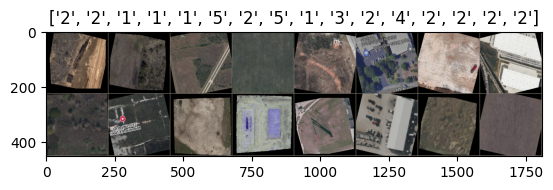

Testing Images:


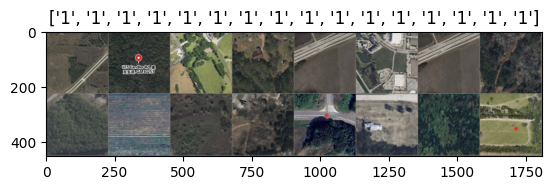

In [13]:
class_names = dataset.classes

print("Training Images:")
show_dataloader_images(train_loader)

print("Testing Images:")
show_dataloader_images(test_loader)

# Modified

In [14]:
def modified_resnet18(num_classes, dropout_probability=0.5):
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(dropout_probability),
        nn.Linear(num_ftrs, num_classes)
    )
    return model

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, dset_loaders, dset_sizes):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dset_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_corrects.double() / dset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model


In [16]:
def run_cross_validation(dataset_path, num_classes=5, num_splits=5, num_epochs=50, learning_rates=[1e-3, 5e-4, 1e-4]):
    dataset = datasets.ImageFolder(root=dataset_path, transform=train_transforms)
    kfold = KFold(n_splits=num_splits, shuffle=True, random_state=42)

    results = []

    for lr in learning_rates:
        fold_accs = []

        for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
            print(f'Training fold {fold+1}/{num_splits} with LR {lr}')

            train_subsampler = Subset(dataset, train_idx)
            val_subsampler = Subset(dataset, val_idx)

            train_loader = DataLoader(train_subsampler, batch_size=16, shuffle=True, num_workers=4)
            val_loader = DataLoader(val_subsampler, batch_size=16, shuffle=False, num_workers=4)

            model = modified_resnet18(num_classes=num_classes, dropout_probability=0.5).to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.fc.parameters(), lr=lr)
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

            trained_model = train_model(model, criterion, optimizer, scheduler, num_epochs, train_loader, val_loader)

            # Evaluate the model on the validation set
            _, preds = torch.max(trained_model(val_loader), 1)
            corrects = torch.sum(preds == val_loader.dataset.targets)
            accuracy = corrects.double() / len(val_loader.dataset)
            fold_accs.append(accuracy.item())

        average_accuracy = np.mean(fold_accs)
        results.append((lr, average_accuracy))
        print(f"Average accuracy for learning rate {lr}: {average_accuracy:.4f}")

    return results

In [44]:
import torch.optim as optim
import time
import copy

num_classes = 5
dropout_probability = 0.5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = modified_resnet18(num_classes, dropout_probability).to(device)

# Setup the criterion, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)  # Only optimize the new layer
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_ft = train_model(model, criterion, optimizer, scheduler, 50, dset_loaders, dset_sizes)

Epoch 1/50
----------
train Loss: 1.6693 Acc: 0.3198
val Loss: 12.3857 Acc: 3.0000
Epoch 2/50
----------
train Loss: 1.5168 Acc: 0.3721
val Loss: 13.3517 Acc: 3.0000
Epoch 3/50
----------
train Loss: 1.4159 Acc: 0.4128
val Loss: 10.7720 Acc: 6.0000
Epoch 4/50
----------
train Loss: 1.3992 Acc: 0.4302
val Loss: 9.8226 Acc: 7.5000
Epoch 5/50
----------
train Loss: 1.3212 Acc: 0.4826
val Loss: 10.9596 Acc: 6.5000
Epoch 6/50
----------
train Loss: 1.1608 Acc: 0.5756
val Loss: 8.7275 Acc: 7.5000
Epoch 7/50
----------
train Loss: 1.2532 Acc: 0.5116
val Loss: 9.7187 Acc: 6.0000
Epoch 8/50
----------
train Loss: 1.1624 Acc: 0.5698
val Loss: 9.2594 Acc: 6.5000
Epoch 9/50
----------
train Loss: 1.1673 Acc: 0.5756
val Loss: 9.1782 Acc: 7.0000
Epoch 10/50
----------
train Loss: 1.1300 Acc: 0.5756
val Loss: 8.8128 Acc: 7.0000
Epoch 11/50
----------
train Loss: 1.1464 Acc: 0.5233
val Loss: 9.0125 Acc: 7.0000
Epoch 12/50
----------
train Loss: 1.1703 Acc: 0.5407
val Loss: 8.9714 Acc: 6.5000
Epoch 13/

In [49]:
from sklearn.model_selection import KFold
import torch
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Subset
from torch import nn, optim
import copy
import numpy as np
from torchvision.transforms.functional import to_tensor, normalize

def my_collate_fn(batch):
    processed_batch = [(train_transforms(img), label) for img, label in batch]
    imgs, labels = zip(*processed_batch)
    imgs = torch.stack(imgs)  # Stacks a list of tensors along a new dimension
    labels = torch.tensor(labels)
    return imgs, labels


# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=15),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.2),
    transforms.ToTensor(),
    normalize
])
val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

# Model modification function with dropout
def modified_resnet18(num_classes, dropout_probability=0.5):
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(dropout_probability),
        nn.Linear(num_ftrs, num_classes)
    )
    return model

# Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs, train_loader, val_loader):
    best_acc = 0.0
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader

            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(loader.dataset)
            epoch_acc = running_corrects.double() / len(loader.dataset)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    return model

# Cross-validation setup
def run_cross_validation(dataset_path, num_classes=5, num_splits=5, num_epochs=50, learning_rates=[1e-3, 5e-4, 1e-4]):
    dataset = datasets.ImageFolder(root=dataset_path)
    kfold = KFold(n_splits=num_splits, shuffle=True, random_state=42)
    results = []

    for lr in learning_rates:
        fold_accs = []
        for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset.samples)):
            print(f'Training fold {fold+1}/{num_splits} with LR {lr}')
            train_subsampler = Subset(dataset, train_idx)
            val_subsampler = Subset(dataset, val_idx)

            # Apply transformations on the fly
            train_loader = DataLoader(train_subsampler, batch_size=16, shuffle=True, num_workers=4, collate_fn= my_collate_fn)
            val_loader = DataLoader(val_subsampler, batch_size=16, shuffle=False, num_workers=4, collate_fn= my_collate_fn)

            model = modified_resnet18(num_classes, 0.5).to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

            trained_model = train_model(model, criterion, optimizer, scheduler, num_epochs, train_loader, val_loader)

            # Evaluate the model on the validation set
            model.eval()
            running_corrects = 0
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = trained_model(inputs)
                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == labels.data)

            accuracy = running_corrects.double() / len(val_subsampler)
            fold_accs.append(accuracy.item())

        average_accuracy = np.mean(fold_accs)
        results.append((lr, average_accuracy))
        print(f"Average accuracy for learning rate {lr}: {average_accuracy:.4f}")

    return results

dataset_path = img_path
run_cross_validation(dataset_path, num_classes=5, num_splits=5, num_epochs=50, learning_rates=[1e-3, 5e-4, 1e-4])


Training fold 1/5 with LR 0.001
Epoch 1/50
train Loss: 1.7275 Acc: 0.2907
val Loss: 1.5964 Acc: 0.3409
Epoch 2/50
train Loss: 1.5203 Acc: 0.4070
val Loss: 1.3695 Acc: 0.4545
Epoch 3/50
train Loss: 1.4731 Acc: 0.4244
val Loss: 1.3201 Acc: 0.5455
Epoch 4/50
train Loss: 1.3797 Acc: 0.4419
val Loss: 1.2109 Acc: 0.6136
Epoch 5/50
train Loss: 1.2871 Acc: 0.5058
val Loss: 1.2202 Acc: 0.6136
Epoch 6/50
train Loss: 1.2304 Acc: 0.5058
val Loss: 1.2130 Acc: 0.6136
Epoch 7/50
train Loss: 1.1843 Acc: 0.4942
val Loss: 1.1283 Acc: 0.6364
Epoch 8/50
train Loss: 1.1519 Acc: 0.5174
val Loss: 1.1211 Acc: 0.6136
Epoch 9/50
train Loss: 1.1616 Acc: 0.5581
val Loss: 1.0843 Acc: 0.6591
Epoch 10/50
train Loss: 1.0954 Acc: 0.6337
val Loss: 1.0215 Acc: 0.6591
Epoch 11/50
train Loss: 1.1147 Acc: 0.6105
val Loss: 1.0151 Acc: 0.6364
Epoch 12/50
train Loss: 1.0796 Acc: 0.6047
val Loss: 1.1153 Acc: 0.5682
Epoch 13/50
train Loss: 1.1427 Acc: 0.5523
val Loss: 1.1342 Acc: 0.6364
Epoch 14/50
train Loss: 1.0459 Acc: 0.627

[(0.001, 0.6662790697674419),
 (0.0005, 0.6528541226215645),
 (0.0001, 0.6068710359408034)]

In [58]:
# @title
data = """ Training fold 1/5 with LR 0.001
Epoch 1/50
train Loss: 1.7275 Acc: 0.2907
val Loss: 1.5964 Acc: 0.3409
Epoch 2/50
train Loss: 1.5203 Acc: 0.4070
val Loss: 1.3695 Acc: 0.4545
Epoch 3/50
train Loss: 1.4731 Acc: 0.4244
val Loss: 1.3201 Acc: 0.5455
Epoch 4/50
train Loss: 1.3797 Acc: 0.4419
val Loss: 1.2109 Acc: 0.6136
Epoch 5/50
train Loss: 1.2871 Acc: 0.5058
val Loss: 1.2202 Acc: 0.6136
Epoch 6/50
train Loss: 1.2304 Acc: 0.5058
val Loss: 1.2130 Acc: 0.6136
Epoch 7/50
train Loss: 1.1843 Acc: 0.4942
val Loss: 1.1283 Acc: 0.6364
Epoch 8/50
train Loss: 1.1519 Acc: 0.5174
val Loss: 1.1211 Acc: 0.6136
Epoch 9/50
train Loss: 1.1616 Acc: 0.5581
val Loss: 1.0843 Acc: 0.6591
Epoch 10/50
train Loss: 1.0954 Acc: 0.6337
val Loss: 1.0215 Acc: 0.6591
Epoch 11/50
train Loss: 1.1147 Acc: 0.6105
val Loss: 1.0151 Acc: 0.6364
Epoch 12/50
train Loss: 1.0796 Acc: 0.6047
val Loss: 1.1153 Acc: 0.5682
Epoch 13/50
train Loss: 1.1427 Acc: 0.5523
val Loss: 1.1342 Acc: 0.6364
Epoch 14/50
train Loss: 1.0459 Acc: 0.6279
val Loss: 1.0699 Acc: 0.5682
Epoch 15/50
train Loss: 0.9676 Acc: 0.6570
val Loss: 1.0603 Acc: 0.6364
Epoch 16/50
train Loss: 1.0353 Acc: 0.5814
val Loss: 0.9395 Acc: 0.6818
Epoch 17/50
train Loss: 0.9508 Acc: 0.6221
val Loss: 0.8933 Acc: 0.6818
Epoch 18/50
train Loss: 1.0314 Acc: 0.5756
val Loss: 1.0227 Acc: 0.6364
Epoch 19/50
train Loss: 0.9580 Acc: 0.5988
val Loss: 1.0402 Acc: 0.6591
Epoch 20/50
train Loss: 0.9774 Acc: 0.6047
val Loss: 1.0048 Acc: 0.6364
Epoch 21/50
train Loss: 0.9871 Acc: 0.5872
val Loss: 0.9290 Acc: 0.7045
Epoch 22/50
train Loss: 0.9545 Acc: 0.6163
val Loss: 1.0645 Acc: 0.6591
Epoch 23/50
train Loss: 0.9347 Acc: 0.6570
val Loss: 0.8788 Acc: 0.7273
Epoch 24/50
train Loss: 0.9263 Acc: 0.6860
val Loss: 0.9818 Acc: 0.6591
Epoch 25/50
train Loss: 0.8951 Acc: 0.6628
val Loss: 0.8512 Acc: 0.7273
Epoch 26/50
train Loss: 0.9238 Acc: 0.6860
val Loss: 0.9236 Acc: 0.7045
Epoch 27/50
train Loss: 0.8924 Acc: 0.6628
val Loss: 0.9141 Acc: 0.7045
Epoch 28/50
train Loss: 0.8821 Acc: 0.6802
val Loss: 1.0292 Acc: 0.5909
Epoch 29/50
train Loss: 0.9009 Acc: 0.6570
val Loss: 0.9828 Acc: 0.6364
Epoch 30/50
train Loss: 0.9377 Acc: 0.6686
val Loss: 1.0202 Acc: 0.6591
Epoch 31/50
train Loss: 0.9283 Acc: 0.5930
val Loss: 1.0205 Acc: 0.6136
Epoch 32/50
train Loss: 0.8415 Acc: 0.6860
val Loss: 0.9000 Acc: 0.7500
Epoch 33/50
train Loss: 0.9181 Acc: 0.6570
val Loss: 0.9165 Acc: 0.6818
Epoch 34/50
train Loss: 0.8416 Acc: 0.7035
val Loss: 0.9598 Acc: 0.6136
Epoch 35/50
train Loss: 0.8294 Acc: 0.6744
val Loss: 0.9396 Acc: 0.6136
Epoch 36/50
train Loss: 0.9780 Acc: 0.6221
val Loss: 0.8979 Acc: 0.7273
Epoch 37/50
train Loss: 0.9188 Acc: 0.6337
val Loss: 1.0419 Acc: 0.7045
Epoch 38/50
train Loss: 0.9045 Acc: 0.6686
val Loss: 0.9450 Acc: 0.6818
Epoch 39/50
train Loss: 0.9360 Acc: 0.6047
val Loss: 0.9421 Acc: 0.6818
Epoch 40/50
train Loss: 0.8867 Acc: 0.6395
val Loss: 0.8350 Acc: 0.6591
Epoch 41/50
train Loss: 0.7715 Acc: 0.7151
val Loss: 0.9930 Acc: 0.6818
Epoch 42/50
train Loss: 0.8799 Acc: 0.6686
val Loss: 0.9206 Acc: 0.6364
Epoch 43/50
train Loss: 0.8945 Acc: 0.6512
val Loss: 1.0038 Acc: 0.6591
Epoch 44/50
train Loss: 0.9532 Acc: 0.6453
val Loss: 0.8763 Acc: 0.7045
Epoch 45/50
train Loss: 1.0495 Acc: 0.6047
val Loss: 0.9761 Acc: 0.6591
Epoch 46/50
train Loss: 0.8730 Acc: 0.6337
val Loss: 1.0801 Acc: 0.5909
Epoch 47/50
train Loss: 0.8799 Acc: 0.6163
val Loss: 1.0112 Acc: 0.7045
Epoch 48/50
train Loss: 0.8396 Acc: 0.6337
val Loss: 0.9569 Acc: 0.6364
Epoch 49/50
train Loss: 0.8262 Acc: 0.6512
val Loss: 0.9543 Acc: 0.6136
Epoch 50/50
train Loss: 0.8295 Acc: 0.6744
val Loss: 1.0786 Acc: 0.6591
Training fold 2/5 with LR 0.001
Epoch 1/50
train Loss: 1.8046 Acc: 0.3179
val Loss: 1.4008 Acc: 0.3721
Epoch 2/50
train Loss: 1.5317 Acc: 0.3295
val Loss: 1.2897 Acc: 0.5116
Epoch 3/50
train Loss: 1.4567 Acc: 0.4277
val Loss: 1.1915 Acc: 0.5581
Epoch 4/50
train Loss: 1.4367 Acc: 0.4104
val Loss: 1.2701 Acc: 0.5581
Epoch 5/50
train Loss: 1.4242 Acc: 0.4104
val Loss: 1.1242 Acc: 0.5814
Epoch 6/50
train Loss: 1.2730 Acc: 0.4566
val Loss: 1.1123 Acc: 0.6279
Epoch 7/50
train Loss: 1.2363 Acc: 0.5087
val Loss: 1.0223 Acc: 0.6512
Epoch 8/50
train Loss: 1.1818 Acc: 0.5260
val Loss: 1.0324 Acc: 0.6512
Epoch 9/50
train Loss: 1.1555 Acc: 0.4913
val Loss: 0.9755 Acc: 0.6744
Epoch 10/50
train Loss: 1.1136 Acc: 0.6127
val Loss: 1.0218 Acc: 0.5814
Epoch 11/50
train Loss: 1.0660 Acc: 0.6474
val Loss: 1.0513 Acc: 0.6279
Epoch 12/50
train Loss: 1.1029 Acc: 0.5607
val Loss: 0.9303 Acc: 0.6744
Epoch 13/50
train Loss: 1.0667 Acc: 0.5838
val Loss: 0.9475 Acc: 0.6047
Epoch 14/50
train Loss: 1.1063 Acc: 0.5607
val Loss: 0.9720 Acc: 0.6047
Epoch 15/50
train Loss: 0.9953 Acc: 0.6647
val Loss: 0.9615 Acc: 0.6744
Epoch 16/50
train Loss: 1.0234 Acc: 0.5780
val Loss: 0.9380 Acc: 0.5814
Epoch 17/50
train Loss: 0.9935 Acc: 0.5549
val Loss: 0.9812 Acc: 0.6512
Epoch 18/50
train Loss: 1.0164 Acc: 0.5954
val Loss: 0.9022 Acc: 0.6512
Epoch 19/50
train Loss: 0.8964 Acc: 0.6879
val Loss: 0.9682 Acc: 0.6512
Epoch 20/50
train Loss: 0.9910 Acc: 0.5665
val Loss: 0.9437 Acc: 0.6744
Epoch 21/50
train Loss: 0.9999 Acc: 0.6590
val Loss: 0.9717 Acc: 0.6047
Epoch 22/50
train Loss: 0.9207 Acc: 0.6301
val Loss: 0.9604 Acc: 0.6279
Epoch 23/50
train Loss: 0.9959 Acc: 0.6358
val Loss: 0.8845 Acc: 0.6279
Epoch 24/50
train Loss: 0.9769 Acc: 0.6243
val Loss: 0.8977 Acc: 0.7209
Epoch 25/50
train Loss: 0.9632 Acc: 0.5954
val Loss: 0.7896 Acc: 0.6744
Epoch 26/50
train Loss: 0.9196 Acc: 0.6301
val Loss: 0.8051 Acc: 0.7442
Epoch 27/50
train Loss: 0.9934 Acc: 0.6127
val Loss: 0.9288 Acc: 0.6744
Epoch 28/50
train Loss: 1.0228 Acc: 0.5780
val Loss: 0.8745 Acc: 0.5814
Epoch 29/50
train Loss: 0.9140 Acc: 0.6821
val Loss: 0.7800 Acc: 0.6977
Epoch 30/50
train Loss: 0.9437 Acc: 0.6416
val Loss: 0.9375 Acc: 0.6744
Epoch 31/50
train Loss: 0.9757 Acc: 0.6185
val Loss: 0.8814 Acc: 0.5349
Epoch 32/50
train Loss: 1.0599 Acc: 0.6185
val Loss: 0.9986 Acc: 0.5581
Epoch 33/50
train Loss: 0.8964 Acc: 0.6012
val Loss: 1.0029 Acc: 0.5814
Epoch 34/50
train Loss: 0.8985 Acc: 0.6474
val Loss: 0.8058 Acc: 0.7209
Epoch 35/50
train Loss: 0.8654 Acc: 0.6590
val Loss: 0.8565 Acc: 0.6977
Epoch 36/50
train Loss: 0.9468 Acc: 0.6763
val Loss: 0.8759 Acc: 0.6512
Epoch 37/50
train Loss: 0.9150 Acc: 0.6474
val Loss: 0.7924 Acc: 0.6977
Epoch 38/50
train Loss: 0.9009 Acc: 0.6127
val Loss: 0.8355 Acc: 0.6977
Epoch 39/50
train Loss: 0.9891 Acc: 0.5723
val Loss: 0.7701 Acc: 0.7442
Epoch 40/50
train Loss: 0.9023 Acc: 0.6532
val Loss: 0.9027 Acc: 0.6512
Epoch 41/50
train Loss: 0.8624 Acc: 0.6532
val Loss: 0.8657 Acc: 0.6744
Epoch 42/50
train Loss: 0.9454 Acc: 0.6474
val Loss: 0.7026 Acc: 0.7674
Epoch 43/50
train Loss: 0.8342 Acc: 0.6821
val Loss: 0.9334 Acc: 0.6977
Epoch 44/50
train Loss: 0.7906 Acc: 0.7052
val Loss: 0.8291 Acc: 0.7209
Epoch 45/50
train Loss: 0.9035 Acc: 0.6358
val Loss: 0.9371 Acc: 0.6279
Epoch 46/50
train Loss: 0.8485 Acc: 0.6994
val Loss: 0.8847 Acc: 0.6279
Epoch 47/50
train Loss: 0.9387 Acc: 0.6416
val Loss: 0.8176 Acc: 0.7907
Epoch 48/50
train Loss: 0.8727 Acc: 0.6243
val Loss: 0.8658 Acc: 0.6512
Epoch 49/50
train Loss: 0.8243 Acc: 0.6821
val Loss: 0.8221 Acc: 0.6977
Epoch 50/50
train Loss: 0.8850 Acc: 0.6532
val Loss: 0.9107 Acc: 0.6744
Training fold 3/5 with LR 0.001
Epoch 1/50
train Loss: 1.7078 Acc: 0.3064
val Loss: 1.6176 Acc: 0.4186
Epoch 2/50
train Loss: 1.5028 Acc: 0.3931
val Loss: 1.3643 Acc: 0.5581
Epoch 3/50
train Loss: 1.3922 Acc: 0.4566
val Loss: 1.3051 Acc: 0.4884
Epoch 4/50
train Loss: 1.3671 Acc: 0.4451
val Loss: 1.2598 Acc: 0.6279
Epoch 5/50
train Loss: 1.3123 Acc: 0.4740
val Loss: 1.2440 Acc: 0.5814
Epoch 6/50
train Loss: 1.2640 Acc: 0.4913
val Loss: 1.2932 Acc: 0.4651
Epoch 7/50
train Loss: 1.1705 Acc: 0.5318
val Loss: 1.0626 Acc: 0.6512
Epoch 8/50
train Loss: 1.2030 Acc: 0.5434
val Loss: 1.1806 Acc: 0.6047
Epoch 9/50
train Loss: 1.1892 Acc: 0.5665
val Loss: 1.1760 Acc: 0.5116
Epoch 10/50
train Loss: 1.0385 Acc: 0.6358
val Loss: 1.1312 Acc: 0.6047
Epoch 11/50
train Loss: 1.0135 Acc: 0.6127
val Loss: 0.9474 Acc: 0.6512
Epoch 12/50
train Loss: 1.0911 Acc: 0.5954
val Loss: 1.0526 Acc: 0.6279
Epoch 13/50
train Loss: 1.0721 Acc: 0.5838
val Loss: 1.0833 Acc: 0.6047
Epoch 14/50
train Loss: 1.0324 Acc: 0.5780
val Loss: 0.9169 Acc: 0.6512
Epoch 15/50
train Loss: 1.0881 Acc: 0.5723
val Loss: 0.8949 Acc: 0.6977
Epoch 16/50
train Loss: 1.0810 Acc: 0.5838
val Loss: 0.9022 Acc: 0.6977
Epoch 17/50
train Loss: 0.9894 Acc: 0.6243
val Loss: 0.9400 Acc: 0.6977
Epoch 18/50
train Loss: 1.0066 Acc: 0.6012
val Loss: 0.9591 Acc: 0.6977
Epoch 19/50
train Loss: 1.0357 Acc: 0.5954
val Loss: 0.9955 Acc: 0.5814
Epoch 20/50
train Loss: 0.9879 Acc: 0.6358
val Loss: 1.0287 Acc: 0.6047
Epoch 21/50
train Loss: 0.9150 Acc: 0.6301
val Loss: 0.9405 Acc: 0.6744
Epoch 22/50
train Loss: 0.9414 Acc: 0.6185
val Loss: 1.0328 Acc: 0.6744
Epoch 23/50
train Loss: 0.9618 Acc: 0.6474
val Loss: 0.8790 Acc: 0.6744
Epoch 24/50
train Loss: 0.9709 Acc: 0.6358
val Loss: 0.9899 Acc: 0.6279
Epoch 25/50
train Loss: 0.9816 Acc: 0.6358
val Loss: 0.8740 Acc: 0.7209
Epoch 26/50
train Loss: 0.9555 Acc: 0.5954
val Loss: 0.8666 Acc: 0.7209
Epoch 27/50
train Loss: 0.8815 Acc: 0.6821
val Loss: 0.9572 Acc: 0.6744
Epoch 28/50
train Loss: 0.8495 Acc: 0.6994
val Loss: 0.8513 Acc: 0.6512
Epoch 29/50
train Loss: 0.9120 Acc: 0.6416
val Loss: 0.9575 Acc: 0.7209
Epoch 30/50
train Loss: 0.8827 Acc: 0.6647
val Loss: 0.9277 Acc: 0.6977
Epoch 31/50
train Loss: 0.9426 Acc: 0.6127
val Loss: 1.0298 Acc: 0.5581
Epoch 32/50
train Loss: 0.9430 Acc: 0.5896
val Loss: 1.0217 Acc: 0.5581
Epoch 33/50
train Loss: 0.8227 Acc: 0.6879
val Loss: 0.8541 Acc: 0.6279
Epoch 34/50
train Loss: 1.0412 Acc: 0.6127
val Loss: 0.9451 Acc: 0.6512
Epoch 35/50
train Loss: 0.9523 Acc: 0.6416
val Loss: 0.8056 Acc: 0.6279
Epoch 36/50
train Loss: 0.8623 Acc: 0.6936
val Loss: 1.0132 Acc: 0.6279
Epoch 37/50
train Loss: 1.0627 Acc: 0.5780
val Loss: 0.8043 Acc: 0.6744
Epoch 38/50
train Loss: 0.8617 Acc: 0.6821
val Loss: 0.9634 Acc: 0.6744
Epoch 39/50
train Loss: 0.8567 Acc: 0.6705
val Loss: 0.9414 Acc: 0.7442
Epoch 40/50
train Loss: 0.9205 Acc: 0.6647
val Loss: 1.0007 Acc: 0.6512
Epoch 41/50
train Loss: 0.9667 Acc: 0.6012
val Loss: 1.0124 Acc: 0.6047
Epoch 42/50
train Loss: 0.9148 Acc: 0.6474
val Loss: 0.9770 Acc: 0.6279
Epoch 43/50
train Loss: 0.9329 Acc: 0.6474
val Loss: 0.8809 Acc: 0.6744
Epoch 44/50
train Loss: 0.9881 Acc: 0.5780
val Loss: 0.9551 Acc: 0.7209
Epoch 45/50
train Loss: 0.8281 Acc: 0.7110
val Loss: 0.9216 Acc: 0.6047
Epoch 46/50
train Loss: 0.8966 Acc: 0.6532
val Loss: 1.0155 Acc: 0.6279
Epoch 47/50
train Loss: 0.8731 Acc: 0.6705
val Loss: 0.8633 Acc: 0.6744
Epoch 48/50
train Loss: 0.9133 Acc: 0.6821
val Loss: 0.8762 Acc: 0.7442
Epoch 49/50
train Loss: 0.8462 Acc: 0.6705
val Loss: 0.8672 Acc: 0.6512
Epoch 50/50
train Loss: 0.9427 Acc: 0.6185
val Loss: 0.7703 Acc: 0.7209
Training fold 4/5 with LR 0.001
Epoch 1/50
train Loss: 1.7365 Acc: 0.2890
val Loss: 1.4381 Acc: 0.4186
Epoch 2/50
train Loss: 1.5603 Acc: 0.3353
val Loss: 1.3317 Acc: 0.3721
Epoch 3/50
train Loss: 1.4524 Acc: 0.4162
val Loss: 1.2641 Acc: 0.5116
Epoch 4/50
train Loss: 1.3748 Acc: 0.3931
val Loss: 1.1360 Acc: 0.5349
Epoch 5/50
train Loss: 1.2595 Acc: 0.5087
val Loss: 1.1072 Acc: 0.5349
Epoch 6/50
train Loss: 1.2494 Acc: 0.5145
val Loss: 1.1423 Acc: 0.5349
Epoch 7/50
train Loss: 1.3140 Acc: 0.4855
val Loss: 1.1397 Acc: 0.5581
Epoch 8/50
train Loss: 1.1309 Acc: 0.5607
val Loss: 1.0473 Acc: 0.5581
Epoch 9/50
train Loss: 1.1099 Acc: 0.6127
val Loss: 1.0658 Acc: 0.5349
Epoch 10/50
train Loss: 1.1566 Acc: 0.6012
val Loss: 1.1599 Acc: 0.5349
Epoch 11/50
train Loss: 1.1321 Acc: 0.5549
val Loss: 0.9174 Acc: 0.6047
Epoch 12/50
train Loss: 1.0838 Acc: 0.5607
val Loss: 0.9654 Acc: 0.6279
Epoch 13/50
train Loss: 1.0359 Acc: 0.5954
val Loss: 0.9196 Acc: 0.6279
Epoch 14/50
train Loss: 1.0095 Acc: 0.6127
val Loss: 0.9745 Acc: 0.6512
Epoch 15/50
train Loss: 1.0466 Acc: 0.5665
val Loss: 0.9642 Acc: 0.6512
Epoch 16/50
train Loss: 0.9617 Acc: 0.6416
val Loss: 0.9189 Acc: 0.6279
Epoch 17/50
train Loss: 0.9172 Acc: 0.6416
val Loss: 0.8970 Acc: 0.5814
Epoch 18/50
train Loss: 1.0063 Acc: 0.6243
val Loss: 0.9640 Acc: 0.5349
Epoch 19/50
train Loss: 0.9830 Acc: 0.6301
val Loss: 0.9482 Acc: 0.6744
Epoch 20/50
train Loss: 0.9984 Acc: 0.6705
val Loss: 0.8667 Acc: 0.6512
Epoch 21/50
train Loss: 1.0147 Acc: 0.5954
val Loss: 0.8348 Acc: 0.6744
Epoch 22/50
train Loss: 0.9648 Acc: 0.6358
val Loss: 0.9309 Acc: 0.6512
Epoch 23/50
train Loss: 0.9485 Acc: 0.6879
val Loss: 0.9477 Acc: 0.6279
Epoch 24/50
train Loss: 0.9979 Acc: 0.6358
val Loss: 0.9011 Acc: 0.6744
Epoch 25/50
train Loss: 1.0014 Acc: 0.6069
val Loss: 0.9479 Acc: 0.6047
Epoch 26/50
train Loss: 0.9460 Acc: 0.6301
val Loss: 0.8746 Acc: 0.6279
Epoch 27/50
train Loss: 0.9178 Acc: 0.6358
val Loss: 1.0083 Acc: 0.5814
Epoch 28/50
train Loss: 0.9453 Acc: 0.6532
val Loss: 0.8921 Acc: 0.6047
Epoch 29/50
train Loss: 0.9504 Acc: 0.6474
val Loss: 0.8530 Acc: 0.6047
Epoch 30/50
train Loss: 0.8353 Acc: 0.6994
val Loss: 0.9010 Acc: 0.6279
Epoch 31/50
train Loss: 0.9235 Acc: 0.6358
val Loss: 0.9242 Acc: 0.6744
Epoch 32/50
train Loss: 0.9167 Acc: 0.6647
val Loss: 0.8024 Acc: 0.6512
Epoch 33/50
train Loss: 0.9364 Acc: 0.6301
val Loss: 1.0133 Acc: 0.6047
Epoch 34/50
train Loss: 0.9245 Acc: 0.6185
val Loss: 0.9519 Acc: 0.6047
Epoch 35/50
train Loss: 1.0297 Acc: 0.6301
val Loss: 0.9661 Acc: 0.6279
Epoch 36/50
train Loss: 0.8299 Acc: 0.6821
val Loss: 0.8500 Acc: 0.6279
Epoch 37/50
train Loss: 0.9708 Acc: 0.6243
val Loss: 0.9272 Acc: 0.6512
Epoch 38/50
train Loss: 0.8531 Acc: 0.7052
val Loss: 0.7443 Acc: 0.7907
Epoch 39/50
train Loss: 1.0003 Acc: 0.6301
val Loss: 0.9284 Acc: 0.6744
Epoch 40/50
train Loss: 0.9189 Acc: 0.6705
val Loss: 1.0186 Acc: 0.5349
Epoch 41/50
train Loss: 1.0102 Acc: 0.5665
val Loss: 0.8222 Acc: 0.6977
Epoch 42/50
train Loss: 0.7304 Acc: 0.6879
val Loss: 0.9281 Acc: 0.5814
Epoch 43/50
train Loss: 0.8351 Acc: 0.6474
val Loss: 0.8266 Acc: 0.6977
Epoch 44/50
train Loss: 0.8919 Acc: 0.6821
val Loss: 0.8116 Acc: 0.7442
Epoch 45/50
train Loss: 0.8903 Acc: 0.6358
val Loss: 0.8568 Acc: 0.7674
Epoch 46/50
train Loss: 0.9126 Acc: 0.6474
val Loss: 0.9521 Acc: 0.5814
Epoch 47/50
train Loss: 0.7784 Acc: 0.7110
val Loss: 0.8204 Acc: 0.6512
Epoch 48/50
train Loss: 0.9488 Acc: 0.6358
val Loss: 0.7952 Acc: 0.6977
Epoch 49/50
train Loss: 0.8652 Acc: 0.6532
val Loss: 0.9247 Acc: 0.6512
Epoch 50/50
train Loss: 0.8704 Acc: 0.6879
val Loss: 0.9086 Acc: 0.6744
Training fold 5/5 with LR 0.001
Epoch 1/50
train Loss: 1.7192 Acc: 0.2717
val Loss: 1.3429 Acc: 0.3953
Epoch 2/50
train Loss: 1.5942 Acc: 0.3353
val Loss: 1.1982 Acc: 0.6512
Epoch 3/50
train Loss: 1.4459 Acc: 0.4104
val Loss: 1.1755 Acc: 0.5116
Epoch 4/50
train Loss: 1.3385 Acc: 0.4740
val Loss: 1.1233 Acc: 0.7209
Epoch 5/50
train Loss: 1.3631 Acc: 0.4682
val Loss: 1.1212 Acc: 0.6047
Epoch 6/50
train Loss: 1.2497 Acc: 0.4971
val Loss: 0.9762 Acc: 0.7209
Epoch 7/50
train Loss: 1.1580 Acc: 0.5491
val Loss: 1.0534 Acc: 0.5814
Epoch 8/50
train Loss: 1.2307 Acc: 0.5376
val Loss: 1.0835 Acc: 0.6977
Epoch 9/50
train Loss: 1.1654 Acc: 0.5491
val Loss: 0.8359 Acc: 0.7442
Epoch 10/50
train Loss: 1.1098 Acc: 0.5896
val Loss: 0.9629 Acc: 0.7209
Epoch 11/50
train Loss: 1.0117 Acc: 0.6127
val Loss: 0.9192 Acc: 0.6977
Epoch 12/50
train Loss: 1.0970 Acc: 0.5838
val Loss: 0.9765 Acc: 0.5581
Epoch 13/50
train Loss: 1.0606 Acc: 0.5896
val Loss: 1.0129 Acc: 0.6977
Epoch 14/50
train Loss: 1.1432 Acc: 0.5318
val Loss: 0.9000 Acc: 0.6977
Epoch 15/50
train Loss: 1.0928 Acc: 0.5723
val Loss: 0.8152 Acc: 0.7209
Epoch 16/50
train Loss: 1.0311 Acc: 0.6185
val Loss: 0.7652 Acc: 0.7209
Epoch 17/50
train Loss: 1.0150 Acc: 0.5954
val Loss: 0.8707 Acc: 0.7442
Epoch 18/50
train Loss: 0.9344 Acc: 0.6069
val Loss: 0.7929 Acc: 0.7442
Epoch 19/50
train Loss: 0.9613 Acc: 0.6474
val Loss: 1.0024 Acc: 0.6744
Epoch 20/50
train Loss: 0.9440 Acc: 0.6358
val Loss: 0.8690 Acc: 0.6977
Epoch 21/50
train Loss: 0.9944 Acc: 0.6705
val Loss: 0.8534 Acc: 0.7674
Epoch 22/50
train Loss: 0.9309 Acc: 0.6185
val Loss: 0.9216 Acc: 0.6279
Epoch 23/50
train Loss: 0.9980 Acc: 0.5954
val Loss: 0.8472 Acc: 0.6977
Epoch 24/50
train Loss: 0.9400 Acc: 0.6301
val Loss: 0.9405 Acc: 0.6977
Epoch 25/50
train Loss: 0.9634 Acc: 0.6590
val Loss: 0.8594 Acc: 0.6744
Epoch 26/50
train Loss: 0.9926 Acc: 0.6185
val Loss: 0.8102 Acc: 0.6977
Epoch 27/50
train Loss: 0.9623 Acc: 0.6301
val Loss: 0.8945 Acc: 0.6744
Epoch 28/50
train Loss: 0.8779 Acc: 0.6416
val Loss: 0.8698 Acc: 0.7209
Epoch 29/50
train Loss: 0.8969 Acc: 0.6069
val Loss: 1.0110 Acc: 0.6279
Epoch 30/50
train Loss: 0.8741 Acc: 0.6821
val Loss: 0.8745 Acc: 0.6744
Epoch 31/50
train Loss: 0.9727 Acc: 0.6012
val Loss: 0.9241 Acc: 0.6977
Epoch 32/50
train Loss: 0.8699 Acc: 0.6705
val Loss: 0.7755 Acc: 0.6512
Epoch 33/50
train Loss: 0.8906 Acc: 0.6705
val Loss: 0.9226 Acc: 0.6744
Epoch 34/50
train Loss: 0.8726 Acc: 0.6821
val Loss: 0.9282 Acc: 0.6279
Epoch 35/50
train Loss: 0.9706 Acc: 0.6127
val Loss: 0.8831 Acc: 0.6744
Epoch 36/50
train Loss: 0.8841 Acc: 0.6532
val Loss: 0.8676 Acc: 0.6744
Epoch 37/50
train Loss: 0.9818 Acc: 0.6301
val Loss: 0.8440 Acc: 0.7442
Epoch 38/50
train Loss: 0.8758 Acc: 0.6936
val Loss: 0.8436 Acc: 0.6977
Epoch 39/50
train Loss: 0.8917 Acc: 0.6301
val Loss: 0.8721 Acc: 0.7209
Epoch 40/50
train Loss: 0.8805 Acc: 0.6590
val Loss: 0.8982 Acc: 0.6977
Epoch 41/50
train Loss: 0.8688 Acc: 0.6474
val Loss: 0.8791 Acc: 0.6744
Epoch 42/50
train Loss: 0.8627 Acc: 0.6705
val Loss: 0.8249 Acc: 0.6977
Epoch 43/50
train Loss: 0.8633 Acc: 0.6590
val Loss: 0.8658 Acc: 0.6744
Epoch 44/50
train Loss: 0.8433 Acc: 0.6763
val Loss: 0.8577 Acc: 0.7209
Epoch 45/50
train Loss: 0.8699 Acc: 0.6705
val Loss: 0.7916 Acc: 0.6977
Epoch 46/50
train Loss: 0.8894 Acc: 0.6474
val Loss: 0.7735 Acc: 0.7674
Epoch 47/50
train Loss: 0.8810 Acc: 0.6301
val Loss: 1.0004 Acc: 0.6744
Epoch 48/50
train Loss: 0.8727 Acc: 0.6301
val Loss: 0.7907 Acc: 0.6977
Epoch 49/50
train Loss: 0.9310 Acc: 0.6243
val Loss: 0.8343 Acc: 0.6512
Epoch 50/50
train Loss: 0.9042 Acc: 0.6416
val Loss: 0.9611 Acc: 0.6744
Average accuracy for learning rate 0.001: 0.6663
Training fold 1/5 with LR 0.0005
Epoch 1/50
train Loss: 1.8055 Acc: 0.2209
val Loss: 1.5615 Acc: 0.4318
Epoch 2/50
train Loss: 1.6747 Acc: 0.3023
val Loss: 1.5705 Acc: 0.4091
Epoch 3/50
train Loss: 1.5314 Acc: 0.3605
val Loss: 1.4463 Acc: 0.4545
Epoch 4/50
train Loss: 1.4663 Acc: 0.3953
val Loss: 1.3789 Acc: 0.4545
Epoch 5/50
train Loss: 1.4190 Acc: 0.4593
val Loss: 1.3500 Acc: 0.4545
Epoch 6/50
train Loss: 1.4451 Acc: 0.4070
val Loss: 1.4220 Acc: 0.5455
Epoch 7/50
train Loss: 1.2702 Acc: 0.5058
val Loss: 1.2677 Acc: 0.6818
Epoch 8/50
train Loss: 1.2945 Acc: 0.5116
val Loss: 1.2459 Acc: 0.5909
Epoch 9/50
train Loss: 1.2535 Acc: 0.4884
val Loss: 1.2257 Acc: 0.6364
Epoch 10/50
train Loss: 1.2691 Acc: 0.4302
val Loss: 1.1890 Acc: 0.5682
Epoch 11/50
train Loss: 1.2763 Acc: 0.5465
val Loss: 1.2512 Acc: 0.6818
Epoch 12/50
train Loss: 1.1801 Acc: 0.5058
val Loss: 1.1894 Acc: 0.5909
Epoch 13/50
train Loss: 1.2974 Acc: 0.5000
val Loss: 1.1604 Acc: 0.6364
Epoch 14/50
train Loss: 1.2210 Acc: 0.5407
val Loss: 1.1607 Acc: 0.6364
Epoch 15/50
train Loss: 1.1746 Acc: 0.5814
val Loss: 1.0917 Acc: 0.6818
Epoch 16/50
train Loss: 1.0712 Acc: 0.5465
val Loss: 0.9842 Acc: 0.6364
Epoch 17/50
train Loss: 1.1329 Acc: 0.5523
val Loss: 1.1189 Acc: 0.6818
Epoch 18/50
train Loss: 1.0611 Acc: 0.6221
val Loss: 1.1890 Acc: 0.6136
Epoch 19/50
train Loss: 1.2058 Acc: 0.5407
val Loss: 1.0763 Acc: 0.6591
Epoch 20/50
train Loss: 1.0965 Acc: 0.5640
val Loss: 1.1246 Acc: 0.6364
Epoch 21/50
train Loss: 1.0722 Acc: 0.5756
val Loss: 1.0318 Acc: 0.6818
Epoch 22/50
train Loss: 1.0514 Acc: 0.5872
val Loss: 1.1613 Acc: 0.6364
Epoch 23/50
train Loss: 1.0995 Acc: 0.5930
val Loss: 1.0065 Acc: 0.7045
Epoch 24/50
train Loss: 0.9851 Acc: 0.6337
val Loss: 1.0344 Acc: 0.6591
Epoch 25/50
train Loss: 0.9936 Acc: 0.6337
val Loss: 1.1356 Acc: 0.6364
Epoch 26/50
train Loss: 1.0862 Acc: 0.5523
val Loss: 1.0088 Acc: 0.6818
Epoch 27/50
train Loss: 0.9441 Acc: 0.6047
val Loss: 1.0814 Acc: 0.6591
Epoch 28/50
train Loss: 1.1400 Acc: 0.5174
val Loss: 0.9942 Acc: 0.7045
Epoch 29/50
train Loss: 0.9950 Acc: 0.6570
val Loss: 0.9799 Acc: 0.6591
Epoch 30/50
train Loss: 1.0980 Acc: 0.5640
val Loss: 0.9830 Acc: 0.6591
Epoch 31/50
train Loss: 0.9664 Acc: 0.6512
val Loss: 1.0981 Acc: 0.6364
Epoch 32/50
train Loss: 0.9691 Acc: 0.6279
val Loss: 1.0252 Acc: 0.6136
Epoch 33/50
train Loss: 0.9915 Acc: 0.5756
val Loss: 0.9525 Acc: 0.6136
Epoch 34/50
train Loss: 0.9184 Acc: 0.6337
val Loss: 1.0833 Acc: 0.6364
Epoch 35/50
train Loss: 0.8814 Acc: 0.6453
val Loss: 1.0008 Acc: 0.6591
Epoch 36/50
train Loss: 0.9443 Acc: 0.6395
val Loss: 1.0641 Acc: 0.5909
Epoch 37/50
train Loss: 0.9941 Acc: 0.6279
val Loss: 0.9233 Acc: 0.6818
Epoch 38/50
train Loss: 0.9873 Acc: 0.6163
val Loss: 0.9491 Acc: 0.6818
Epoch 39/50
train Loss: 0.9586 Acc: 0.6337
val Loss: 1.0666 Acc: 0.7045
Epoch 40/50
train Loss: 0.9344 Acc: 0.6512
val Loss: 0.9089 Acc: 0.6364
Epoch 41/50
train Loss: 0.9775 Acc: 0.6221
val Loss: 1.0778 Acc: 0.6136
Epoch 42/50
train Loss: 0.8709 Acc: 0.6919
val Loss: 0.9929 Acc: 0.6136
Epoch 43/50
train Loss: 0.9347 Acc: 0.6744
val Loss: 0.9590 Acc: 0.6591
Epoch 44/50
train Loss: 0.9427 Acc: 0.6628
val Loss: 0.9811 Acc: 0.6136
Epoch 45/50
train Loss: 0.9182 Acc: 0.6395
val Loss: 0.9756 Acc: 0.6818
Epoch 46/50
train Loss: 0.9554 Acc: 0.6570
val Loss: 0.9854 Acc: 0.6591
Epoch 47/50
train Loss: 0.9741 Acc: 0.6047
val Loss: 0.9766 Acc: 0.6818
Epoch 48/50
train Loss: 0.8649 Acc: 0.6686
val Loss: 0.9240 Acc: 0.7045
Epoch 49/50
train Loss: 0.9565 Acc: 0.6337
val Loss: 0.8514 Acc: 0.7045
Epoch 50/50
train Loss: 0.9475 Acc: 0.6221
val Loss: 0.9175 Acc: 0.6818
Training fold 2/5 with LR 0.0005
Epoch 1/50
train Loss: 1.5516 Acc: 0.3584
val Loss: 1.3840 Acc: 0.4186
Epoch 2/50
train Loss: 1.4969 Acc: 0.3815
val Loss: 1.3382 Acc: 0.4419
Epoch 3/50
train Loss: 1.4510 Acc: 0.3584
val Loss: 1.3204 Acc: 0.3953
Epoch 4/50
train Loss: 1.5087 Acc: 0.3468
val Loss: 1.3361 Acc: 0.4651
Epoch 5/50
train Loss: 1.3860 Acc: 0.4162
val Loss: 1.2251 Acc: 0.4651
Epoch 6/50
train Loss: 1.3453 Acc: 0.5087
val Loss: 1.1756 Acc: 0.5581
Epoch 7/50
train Loss: 1.3477 Acc: 0.4624
val Loss: 1.2066 Acc: 0.5349
Epoch 8/50
train Loss: 1.2645 Acc: 0.5260
val Loss: 1.2197 Acc: 0.6047
Epoch 9/50
train Loss: 1.2762 Acc: 0.5029
val Loss: 1.1737 Acc: 0.5814
Epoch 10/50
train Loss: 1.2454 Acc: 0.5087
val Loss: 1.0089 Acc: 0.6977
Epoch 11/50
train Loss: 1.1277 Acc: 0.5260
val Loss: 1.1485 Acc: 0.5814
Epoch 12/50
train Loss: 1.2243 Acc: 0.5087
val Loss: 1.1147 Acc: 0.6047
Epoch 13/50
train Loss: 1.1723 Acc: 0.5434
val Loss: 1.0729 Acc: 0.6279
Epoch 14/50
train Loss: 1.1507 Acc: 0.5665
val Loss: 1.2052 Acc: 0.5349
Epoch 15/50
train Loss: 1.1375 Acc: 0.5434
val Loss: 1.0111 Acc: 0.6512
Epoch 16/50
train Loss: 1.1143 Acc: 0.5665
val Loss: 1.0554 Acc: 0.5581
Epoch 17/50
train Loss: 1.1693 Acc: 0.5780
val Loss: 1.0593 Acc: 0.5349
Epoch 18/50
train Loss: 1.0596 Acc: 0.5607
val Loss: 1.0486 Acc: 0.6512
Epoch 19/50
train Loss: 1.0936 Acc: 0.6243
val Loss: 0.9524 Acc: 0.6744
Epoch 20/50
train Loss: 1.0967 Acc: 0.5780
val Loss: 1.1013 Acc: 0.5814
Epoch 21/50
train Loss: 1.1143 Acc: 0.6127
val Loss: 0.9476 Acc: 0.6279
Epoch 22/50
train Loss: 1.0298 Acc: 0.6185
val Loss: 1.0087 Acc: 0.5814
Epoch 23/50
train Loss: 1.1192 Acc: 0.5838
val Loss: 0.9938 Acc: 0.6744
Epoch 24/50
train Loss: 0.9457 Acc: 0.6243
val Loss: 1.0836 Acc: 0.6047
Epoch 25/50
train Loss: 0.9669 Acc: 0.6416
val Loss: 1.0054 Acc: 0.6512
Epoch 26/50
train Loss: 1.0386 Acc: 0.5954
val Loss: 0.9715 Acc: 0.6744
Epoch 27/50
train Loss: 0.9515 Acc: 0.6127
val Loss: 0.9993 Acc: 0.6279
Epoch 28/50
train Loss: 0.9908 Acc: 0.5665
val Loss: 0.9957 Acc: 0.6279
Epoch 29/50
train Loss: 1.0168 Acc: 0.6416
val Loss: 0.8826 Acc: 0.5349
Epoch 30/50
train Loss: 0.9742 Acc: 0.6069
val Loss: 0.9832 Acc: 0.6279
Epoch 31/50
train Loss: 1.0136 Acc: 0.5896
val Loss: 0.8796 Acc: 0.6977
Epoch 32/50
train Loss: 0.9498 Acc: 0.6474
val Loss: 0.9955 Acc: 0.6279
Epoch 33/50
train Loss: 1.0647 Acc: 0.5896
val Loss: 0.9599 Acc: 0.6279
Epoch 34/50
train Loss: 0.8928 Acc: 0.6647
val Loss: 0.9772 Acc: 0.6512
Epoch 35/50
train Loss: 0.9837 Acc: 0.6301
val Loss: 0.9185 Acc: 0.6047
Epoch 36/50
train Loss: 0.9673 Acc: 0.6416
val Loss: 0.9240 Acc: 0.6047
Epoch 37/50
train Loss: 0.9457 Acc: 0.6590
val Loss: 0.9886 Acc: 0.6279
Epoch 38/50
train Loss: 1.0347 Acc: 0.5723
val Loss: 0.9815 Acc: 0.6047
Epoch 39/50
train Loss: 0.9620 Acc: 0.5954
val Loss: 0.9152 Acc: 0.6744
Epoch 40/50
train Loss: 0.9892 Acc: 0.6590
val Loss: 1.0383 Acc: 0.6512
Epoch 41/50
train Loss: 0.9194 Acc: 0.6358
val Loss: 0.9560 Acc: 0.5581
Epoch 42/50
train Loss: 0.9432 Acc: 0.6474
val Loss: 0.9567 Acc: 0.6279
Epoch 43/50
train Loss: 1.0722 Acc: 0.5780
val Loss: 0.8495 Acc: 0.6744
Epoch 44/50
train Loss: 0.9036 Acc: 0.6301
val Loss: 0.8690 Acc: 0.6977
Epoch 45/50
train Loss: 0.9291 Acc: 0.6301
val Loss: 0.8360 Acc: 0.6977
Epoch 46/50
train Loss: 0.9902 Acc: 0.5723
val Loss: 0.9484 Acc: 0.6512
Epoch 47/50
train Loss: 0.9746 Acc: 0.6127
val Loss: 0.7990 Acc: 0.6744
Epoch 48/50
train Loss: 0.9865 Acc: 0.6301
val Loss: 0.9070 Acc: 0.6744
Epoch 49/50
train Loss: 0.9576 Acc: 0.6185
val Loss: 0.9304 Acc: 0.5814
Epoch 50/50
train Loss: 0.9255 Acc: 0.6590
val Loss: 0.9202 Acc: 0.6279
Training fold 3/5 with LR 0.0005
Epoch 1/50
train Loss: 1.7294 Acc: 0.2370
val Loss: 1.5048 Acc: 0.4186
Epoch 2/50
train Loss: 1.5584 Acc: 0.3410
val Loss: 1.5490 Acc: 0.4419
Epoch 3/50
train Loss: 1.5243 Acc: 0.3699
val Loss: 1.4838 Acc: 0.5349
Epoch 4/50
train Loss: 1.5117 Acc: 0.3468
val Loss: 1.3861 Acc: 0.3953
Epoch 5/50
train Loss: 1.4489 Acc: 0.4566
val Loss: 1.3968 Acc: 0.4884
Epoch 6/50
train Loss: 1.3451 Acc: 0.4451
val Loss: 1.3346 Acc: 0.4651
Epoch 7/50
train Loss: 1.3163 Acc: 0.4220
val Loss: 1.2325 Acc: 0.6512
Epoch 8/50
train Loss: 1.3224 Acc: 0.5260
val Loss: 1.1921 Acc: 0.5581
Epoch 9/50
train Loss: 1.2733 Acc: 0.5376
val Loss: 1.2325 Acc: 0.5116
Epoch 10/50
train Loss: 1.2809 Acc: 0.5260
val Loss: 1.2458 Acc: 0.5581
Epoch 11/50
train Loss: 1.2807 Acc: 0.5145
val Loss: 1.1846 Acc: 0.6279
Epoch 12/50
train Loss: 1.1761 Acc: 0.5434
val Loss: 1.1687 Acc: 0.5581
Epoch 13/50
train Loss: 1.2210 Acc: 0.5318
val Loss: 1.1757 Acc: 0.5814
Epoch 14/50
train Loss: 1.2067 Acc: 0.5029
val Loss: 1.1517 Acc: 0.6047
Epoch 15/50
train Loss: 1.1363 Acc: 0.5434
val Loss: 1.1410 Acc: 0.6047
Epoch 16/50
train Loss: 1.1637 Acc: 0.5376
val Loss: 1.0566 Acc: 0.6047
Epoch 17/50
train Loss: 1.0785 Acc: 0.5896
val Loss: 1.1272 Acc: 0.5581
Epoch 18/50
train Loss: 1.1836 Acc: 0.5029
val Loss: 1.1237 Acc: 0.5814
Epoch 19/50
train Loss: 1.1459 Acc: 0.5607
val Loss: 1.1891 Acc: 0.5581
Epoch 20/50
train Loss: 1.1393 Acc: 0.5723
val Loss: 1.1134 Acc: 0.6047
Epoch 21/50
train Loss: 1.1232 Acc: 0.5318
val Loss: 1.0107 Acc: 0.6744
Epoch 22/50
train Loss: 1.0278 Acc: 0.5780
val Loss: 1.0293 Acc: 0.6279
Epoch 23/50
train Loss: 1.0882 Acc: 0.6069
val Loss: 1.0189 Acc: 0.6977
Epoch 24/50
train Loss: 1.0323 Acc: 0.6069
val Loss: 1.0171 Acc: 0.6279
Epoch 25/50
train Loss: 1.0507 Acc: 0.5896
val Loss: 1.1029 Acc: 0.6047
Epoch 26/50
train Loss: 1.0840 Acc: 0.5954
val Loss: 1.0104 Acc: 0.5349
Epoch 27/50
train Loss: 1.1154 Acc: 0.5260
val Loss: 1.0137 Acc: 0.6512
Epoch 28/50
train Loss: 1.0586 Acc: 0.6243
val Loss: 0.9771 Acc: 0.6047
Epoch 29/50
train Loss: 0.9742 Acc: 0.6243
val Loss: 1.0104 Acc: 0.6047
Epoch 30/50
train Loss: 1.0330 Acc: 0.5954
val Loss: 0.9879 Acc: 0.5814
Epoch 31/50
train Loss: 1.0150 Acc: 0.5838
val Loss: 0.9544 Acc: 0.7209
Epoch 32/50
train Loss: 1.0656 Acc: 0.5896
val Loss: 1.0198 Acc: 0.6279
Epoch 33/50
train Loss: 1.0272 Acc: 0.6012
val Loss: 1.0051 Acc: 0.6744
Epoch 34/50
train Loss: 1.0109 Acc: 0.5723
val Loss: 0.9329 Acc: 0.6744
Epoch 35/50
train Loss: 0.9475 Acc: 0.6763
val Loss: 1.0207 Acc: 0.6977
Epoch 36/50
train Loss: 0.9797 Acc: 0.6069
val Loss: 0.9623 Acc: 0.6279
Epoch 37/50
train Loss: 0.9794 Acc: 0.6243
val Loss: 0.9310 Acc: 0.7209
Epoch 38/50
train Loss: 0.8879 Acc: 0.6416
val Loss: 0.9439 Acc: 0.6744
Epoch 39/50
train Loss: 1.0413 Acc: 0.6012
val Loss: 0.9939 Acc: 0.6977
Epoch 40/50
train Loss: 0.9285 Acc: 0.6243
val Loss: 1.0230 Acc: 0.5814
Epoch 41/50
train Loss: 0.9870 Acc: 0.6358
val Loss: 0.9975 Acc: 0.5814
Epoch 42/50
train Loss: 1.0304 Acc: 0.5954
val Loss: 1.0341 Acc: 0.5581
Epoch 43/50
train Loss: 0.9224 Acc: 0.6127
val Loss: 0.8803 Acc: 0.6279
Epoch 44/50
train Loss: 0.8632 Acc: 0.6821
val Loss: 0.9120 Acc: 0.6744
Epoch 45/50
train Loss: 0.8720 Acc: 0.6474
val Loss: 0.9364 Acc: 0.6279
Epoch 46/50
train Loss: 0.8950 Acc: 0.6358
val Loss: 1.0058 Acc: 0.6279
Epoch 47/50
train Loss: 0.9408 Acc: 0.6243
val Loss: 1.0304 Acc: 0.6047
Epoch 48/50
train Loss: 0.8892 Acc: 0.6590
val Loss: 0.9487 Acc: 0.6279
Epoch 49/50
train Loss: 0.8955 Acc: 0.6763
val Loss: 0.9504 Acc: 0.6744
Epoch 50/50
train Loss: 0.9515 Acc: 0.6358
val Loss: 0.9252 Acc: 0.6744
Training fold 4/5 with LR 0.0005
Epoch 1/50
train Loss: 1.8165 Acc: 0.1734
val Loss: 1.5344 Acc: 0.2326
Epoch 2/50
train Loss: 1.5445 Acc: 0.3121
val Loss: 1.5037 Acc: 0.2326
Epoch 3/50
train Loss: 1.5224 Acc: 0.3931
val Loss: 1.3818 Acc: 0.4186
Epoch 4/50
train Loss: 1.5450 Acc: 0.3584
val Loss: 1.3846 Acc: 0.4651
Epoch 5/50
train Loss: 1.4712 Acc: 0.3931
val Loss: 1.2857 Acc: 0.5116
Epoch 6/50
train Loss: 1.4708 Acc: 0.3988
val Loss: 1.3973 Acc: 0.3953
Epoch 7/50
train Loss: 1.2956 Acc: 0.4913
val Loss: 1.2828 Acc: 0.4419
Epoch 8/50
train Loss: 1.2825 Acc: 0.4682
val Loss: 1.2420 Acc: 0.5116
Epoch 9/50
train Loss: 1.2801 Acc: 0.4798
val Loss: 1.2020 Acc: 0.4651
Epoch 10/50
train Loss: 1.3328 Acc: 0.4566
val Loss: 1.2448 Acc: 0.4651
Epoch 11/50
train Loss: 1.2966 Acc: 0.4913
val Loss: 1.1825 Acc: 0.5814
Epoch 12/50
train Loss: 1.2953 Acc: 0.5260
val Loss: 1.1746 Acc: 0.5116
Epoch 13/50
train Loss: 1.2634 Acc: 0.5029
val Loss: 1.1718 Acc: 0.5349
Epoch 14/50
train Loss: 1.2207 Acc: 0.5029
val Loss: 1.0980 Acc: 0.4884
Epoch 15/50
train Loss: 1.2336 Acc: 0.5318
val Loss: 1.0020 Acc: 0.6744
Epoch 16/50
train Loss: 1.1516 Acc: 0.5665
val Loss: 1.1426 Acc: 0.5116
Epoch 17/50
train Loss: 1.1504 Acc: 0.5665
val Loss: 1.0758 Acc: 0.5814
Epoch 18/50
train Loss: 1.0510 Acc: 0.6243
val Loss: 1.0622 Acc: 0.5349
Epoch 19/50
train Loss: 1.0993 Acc: 0.6127
val Loss: 1.0229 Acc: 0.6047
Epoch 20/50
train Loss: 1.1804 Acc: 0.5491
val Loss: 1.1204 Acc: 0.4651
Epoch 21/50
train Loss: 1.0827 Acc: 0.5434
val Loss: 1.0416 Acc: 0.5814
Epoch 22/50
train Loss: 1.0743 Acc: 0.6127
val Loss: 0.9920 Acc: 0.6047
Epoch 23/50
train Loss: 1.0783 Acc: 0.6069
val Loss: 0.9511 Acc: 0.5814
Epoch 24/50
train Loss: 1.0908 Acc: 0.6069
val Loss: 1.0844 Acc: 0.5581
Epoch 25/50
train Loss: 1.1619 Acc: 0.5491
val Loss: 0.9783 Acc: 0.6047
Epoch 26/50
train Loss: 1.0597 Acc: 0.5954
val Loss: 0.9930 Acc: 0.6047
Epoch 27/50
train Loss: 1.0426 Acc: 0.5665
val Loss: 0.9366 Acc: 0.6512
Epoch 28/50
train Loss: 1.0599 Acc: 0.6185
val Loss: 0.9610 Acc: 0.6744
Epoch 29/50
train Loss: 1.0349 Acc: 0.6012
val Loss: 0.9862 Acc: 0.5581
Epoch 30/50
train Loss: 0.9965 Acc: 0.6416
val Loss: 1.0344 Acc: 0.5349
Epoch 31/50
train Loss: 0.9890 Acc: 0.6301
val Loss: 0.9983 Acc: 0.4884
Epoch 32/50
train Loss: 1.0567 Acc: 0.6301
val Loss: 0.9440 Acc: 0.6279
Epoch 33/50
train Loss: 0.9619 Acc: 0.6474
val Loss: 0.9407 Acc: 0.6279
Epoch 34/50
train Loss: 1.0248 Acc: 0.6243
val Loss: 0.8529 Acc: 0.6977
Epoch 35/50
train Loss: 1.0500 Acc: 0.5896
val Loss: 0.9508 Acc: 0.6047
Epoch 36/50
train Loss: 0.9823 Acc: 0.6127
val Loss: 0.9188 Acc: 0.6512
Epoch 37/50
train Loss: 1.0091 Acc: 0.6474
val Loss: 0.9185 Acc: 0.6047
Epoch 38/50
train Loss: 1.0039 Acc: 0.6416
val Loss: 0.8479 Acc: 0.6512
Epoch 39/50
train Loss: 0.9299 Acc: 0.6243
val Loss: 0.8979 Acc: 0.6512
Epoch 40/50
train Loss: 0.9072 Acc: 0.6763
val Loss: 0.9720 Acc: 0.6744
Epoch 41/50
train Loss: 0.9933 Acc: 0.6474
val Loss: 0.9530 Acc: 0.6512
Epoch 42/50
train Loss: 0.9477 Acc: 0.6301
val Loss: 0.9502 Acc: 0.5814
Epoch 43/50
train Loss: 0.9088 Acc: 0.6647
val Loss: 1.0047 Acc: 0.5581
Epoch 44/50
train Loss: 0.9929 Acc: 0.6127
val Loss: 0.8661 Acc: 0.6512
Epoch 45/50
train Loss: 0.9833 Acc: 0.6358
val Loss: 0.8961 Acc: 0.6047
Epoch 46/50
train Loss: 0.9154 Acc: 0.6416
val Loss: 0.9472 Acc: 0.6047
Epoch 47/50
train Loss: 0.9092 Acc: 0.6532
val Loss: 1.0064 Acc: 0.6512
Epoch 48/50
train Loss: 0.8923 Acc: 0.6705
val Loss: 0.9699 Acc: 0.6047
Epoch 49/50
train Loss: 0.8728 Acc: 0.6821
val Loss: 0.9711 Acc: 0.6744
Epoch 50/50
train Loss: 0.8089 Acc: 0.6994
val Loss: 0.8291 Acc: 0.6977
Training fold 5/5 with LR 0.0005
Epoch 1/50
train Loss: 1.7631 Acc: 0.2428
val Loss: 1.4488 Acc: 0.3023
Epoch 2/50
train Loss: 1.6605 Acc: 0.3295
val Loss: 1.3923 Acc: 0.3953
Epoch 3/50
train Loss: 1.5966 Acc: 0.3584
val Loss: 1.3221 Acc: 0.4186
Epoch 4/50
train Loss: 1.5050 Acc: 0.3873
val Loss: 1.3340 Acc: 0.4884
Epoch 5/50
train Loss: 1.4384 Acc: 0.3642
val Loss: 1.2629 Acc: 0.4651
Epoch 6/50
train Loss: 1.3397 Acc: 0.4566
val Loss: 1.2546 Acc: 0.4186
Epoch 7/50
train Loss: 1.4579 Acc: 0.4566
val Loss: 1.1808 Acc: 0.5581
Epoch 8/50
train Loss: 1.3251 Acc: 0.4798
val Loss: 1.1394 Acc: 0.6279
Epoch 9/50
train Loss: 1.3014 Acc: 0.4740
val Loss: 1.1144 Acc: 0.6047
Epoch 10/50
train Loss: 1.3158 Acc: 0.4624
val Loss: 1.1568 Acc: 0.5814
Epoch 11/50
train Loss: 1.3150 Acc: 0.4451
val Loss: 1.1395 Acc: 0.5349
Epoch 12/50
train Loss: 1.1748 Acc: 0.5607
val Loss: 1.0872 Acc: 0.5349
Epoch 13/50
train Loss: 1.2431 Acc: 0.4798
val Loss: 1.1175 Acc: 0.5814
Epoch 14/50
train Loss: 1.1994 Acc: 0.5780
val Loss: 1.0713 Acc: 0.6512
Epoch 15/50
train Loss: 1.1838 Acc: 0.5723
val Loss: 1.1766 Acc: 0.5349
Epoch 16/50
train Loss: 1.1448 Acc: 0.5607
val Loss: 1.0530 Acc: 0.6047
Epoch 17/50
train Loss: 1.1082 Acc: 0.5665
val Loss: 1.0511 Acc: 0.5349
Epoch 18/50
train Loss: 1.0853 Acc: 0.5896
val Loss: 1.0401 Acc: 0.6977
Epoch 19/50
train Loss: 1.1809 Acc: 0.5318
val Loss: 0.9924 Acc: 0.7209
Epoch 20/50
train Loss: 1.0640 Acc: 0.6069
val Loss: 1.0469 Acc: 0.7209
Epoch 21/50
train Loss: 1.0755 Acc: 0.5723
val Loss: 0.8928 Acc: 0.6512
Epoch 22/50
train Loss: 1.0621 Acc: 0.6358
val Loss: 1.0708 Acc: 0.6512
Epoch 23/50
train Loss: 1.0924 Acc: 0.5723
val Loss: 0.9717 Acc: 0.6744
Epoch 24/50
train Loss: 0.9796 Acc: 0.6705
val Loss: 0.9177 Acc: 0.7209
Epoch 25/50
train Loss: 1.1006 Acc: 0.5780
val Loss: 1.0188 Acc: 0.6512
Epoch 26/50
train Loss: 1.1121 Acc: 0.5202
val Loss: 0.9016 Acc: 0.7209
Epoch 27/50
train Loss: 1.0092 Acc: 0.5780
val Loss: 0.9452 Acc: 0.6512
Epoch 28/50
train Loss: 1.0603 Acc: 0.6185
val Loss: 0.8734 Acc: 0.6977
Epoch 29/50
train Loss: 0.9894 Acc: 0.5896
val Loss: 0.9513 Acc: 0.6977
Epoch 30/50
train Loss: 1.0481 Acc: 0.5318
val Loss: 0.9109 Acc: 0.7674
Epoch 31/50
train Loss: 1.0195 Acc: 0.6301
val Loss: 0.8915 Acc: 0.7442
Epoch 32/50
train Loss: 1.0683 Acc: 0.5376
val Loss: 0.8951 Acc: 0.6512
Epoch 33/50
train Loss: 1.0404 Acc: 0.5491
val Loss: 0.9683 Acc: 0.6977
Epoch 34/50
train Loss: 1.0488 Acc: 0.5723
val Loss: 0.8840 Acc: 0.6744
Epoch 35/50
train Loss: 1.0544 Acc: 0.5780
val Loss: 1.0069 Acc: 0.6744
Epoch 36/50
train Loss: 0.9975 Acc: 0.6185
val Loss: 0.9399 Acc: 0.6279
Epoch 37/50
train Loss: 0.9796 Acc: 0.6069
val Loss: 0.9126 Acc: 0.6977
Epoch 38/50
train Loss: 0.9811 Acc: 0.6069
val Loss: 0.8325 Acc: 0.6977
Epoch 39/50
train Loss: 0.9763 Acc: 0.6069
val Loss: 0.9305 Acc: 0.7209
Epoch 40/50
train Loss: 0.9803 Acc: 0.6243
val Loss: 0.9164 Acc: 0.6512
Epoch 41/50
train Loss: 1.0646 Acc: 0.5896
val Loss: 0.8856 Acc: 0.7209
Epoch 42/50
train Loss: 0.9991 Acc: 0.5780
val Loss: 0.9343 Acc: 0.6512
Epoch 43/50
train Loss: 0.9114 Acc: 0.6358
val Loss: 0.8666 Acc: 0.7442
Epoch 44/50
train Loss: 0.9246 Acc: 0.6532
val Loss: 0.9230 Acc: 0.7209
Epoch 45/50
train Loss: 0.9506 Acc: 0.6243
val Loss: 0.9618 Acc: 0.6512
Epoch 46/50
train Loss: 1.0174 Acc: 0.5896
val Loss: 0.8490 Acc: 0.7674
Epoch 47/50
train Loss: 0.9985 Acc: 0.6416
val Loss: 0.9777 Acc: 0.5814
Epoch 48/50
train Loss: 0.8662 Acc: 0.6705
val Loss: 0.8980 Acc: 0.7442
Epoch 49/50
train Loss: 0.9508 Acc: 0.6358
val Loss: 0.9306 Acc: 0.6744
Epoch 50/50
train Loss: 0.9055 Acc: 0.6416
val Loss: 0.7567 Acc: 0.7674
Average accuracy for learning rate 0.0005: 0.6529
Training fold 1/5 with LR 0.0001
Epoch 1/50
train Loss: 2.0109 Acc: 0.1512
val Loss: 1.6968 Acc: 0.2273
Epoch 2/50
train Loss: 1.9061 Acc: 0.1570
val Loss: 1.5944 Acc: 0.2955
Epoch 3/50
train Loss: 1.7072 Acc: 0.2384
val Loss: 1.6447 Acc: 0.3409
Epoch 4/50
train Loss: 1.6719 Acc: 0.2965
val Loss: 1.6574 Acc: 0.2500
Epoch 5/50
train Loss: 1.5683 Acc: 0.2791
val Loss: 1.6653 Acc: 0.2500
Epoch 6/50
train Loss: 1.6402 Acc: 0.3023
val Loss: 1.6040 Acc: 0.2273
Epoch 7/50
train Loss: 1.6303 Acc: 0.3605
val Loss: 1.5995 Acc: 0.2045
Epoch 8/50
train Loss: 1.6061 Acc: 0.2907
val Loss: 1.6233 Acc: 0.2500
Epoch 9/50
train Loss: 1.5527 Acc: 0.3488
val Loss: 1.5863 Acc: 0.2500
Epoch 10/50
train Loss: 1.6701 Acc: 0.3198
val Loss: 1.6213 Acc: 0.2045
Epoch 11/50
train Loss: 1.5736 Acc: 0.3140
val Loss: 1.5545 Acc: 0.2500
Epoch 12/50
train Loss: 1.6303 Acc: 0.3314
val Loss: 1.6156 Acc: 0.2727
Epoch 13/50
train Loss: 1.5055 Acc: 0.3837
val Loss: 1.5835 Acc: 0.2727
Epoch 14/50
train Loss: 1.6093 Acc: 0.3140
val Loss: 1.5250 Acc: 0.2727
Epoch 15/50
train Loss: 1.5183 Acc: 0.3895
val Loss: 1.5985 Acc: 0.2273
Epoch 16/50
train Loss: 1.5691 Acc: 0.3605
val Loss: 1.4945 Acc: 0.2727
Epoch 17/50
train Loss: 1.5291 Acc: 0.3198
val Loss: 1.5358 Acc: 0.3409
Epoch 18/50
train Loss: 1.4610 Acc: 0.3953
val Loss: 1.5947 Acc: 0.3182
Epoch 19/50
train Loss: 1.6061 Acc: 0.3140
val Loss: 1.4437 Acc: 0.3409
Epoch 20/50
train Loss: 1.4628 Acc: 0.3953
val Loss: 1.5047 Acc: 0.4091
Epoch 21/50
train Loss: 1.4846 Acc: 0.3895
val Loss: 1.4602 Acc: 0.3409
Epoch 22/50
train Loss: 1.4125 Acc: 0.4302
val Loss: 1.5567 Acc: 0.3182
Epoch 23/50
train Loss: 1.4526 Acc: 0.3721
val Loss: 1.5064 Acc: 0.3409
Epoch 24/50
train Loss: 1.4538 Acc: 0.3721
val Loss: 1.4701 Acc: 0.4091
Epoch 25/50
train Loss: 1.5137 Acc: 0.3430
val Loss: 1.3911 Acc: 0.4318
Epoch 26/50
train Loss: 1.4844 Acc: 0.4070
val Loss: 1.4080 Acc: 0.4318
Epoch 27/50
train Loss: 1.5186 Acc: 0.3547
val Loss: 1.3972 Acc: 0.4318
Epoch 28/50
train Loss: 1.3803 Acc: 0.4128
val Loss: 1.4225 Acc: 0.4773
Epoch 29/50
train Loss: 1.4033 Acc: 0.4360
val Loss: 1.4341 Acc: 0.3636
Epoch 30/50
train Loss: 1.3811 Acc: 0.4186
val Loss: 1.3339 Acc: 0.4545
Epoch 31/50
train Loss: 1.4446 Acc: 0.4302
val Loss: 1.4465 Acc: 0.4318
Epoch 32/50
train Loss: 1.4141 Acc: 0.4070
val Loss: 1.4015 Acc: 0.4091
Epoch 33/50
train Loss: 1.3674 Acc: 0.4302
val Loss: 1.3590 Acc: 0.3409
Epoch 34/50
train Loss: 1.4085 Acc: 0.3605
val Loss: 1.3555 Acc: 0.4773
Epoch 35/50
train Loss: 1.3969 Acc: 0.4012
val Loss: 1.3809 Acc: 0.4545
Epoch 36/50
train Loss: 1.3950 Acc: 0.4360
val Loss: 1.4006 Acc: 0.3636
Epoch 37/50
train Loss: 1.3577 Acc: 0.4302
val Loss: 1.2909 Acc: 0.5227
Epoch 38/50
train Loss: 1.4019 Acc: 0.3721
val Loss: 1.2956 Acc: 0.5455
Epoch 39/50
train Loss: 1.3820 Acc: 0.4128
val Loss: 1.3437 Acc: 0.4773
Epoch 40/50
train Loss: 1.3621 Acc: 0.4070
val Loss: 1.4020 Acc: 0.5455
Epoch 41/50
train Loss: 1.3684 Acc: 0.5000
val Loss: 1.3981 Acc: 0.4773
Epoch 42/50
train Loss: 1.3158 Acc: 0.4419
val Loss: 1.3465 Acc: 0.4773
Epoch 43/50
train Loss: 1.2945 Acc: 0.4709
val Loss: 1.3230 Acc: 0.5909
Epoch 44/50
train Loss: 1.3140 Acc: 0.4651
val Loss: 1.3017 Acc: 0.5227
Epoch 45/50
train Loss: 1.2372 Acc: 0.5174
val Loss: 1.3153 Acc: 0.5227
Epoch 46/50
train Loss: 1.2831 Acc: 0.4942
val Loss: 1.3602 Acc: 0.4318
Epoch 47/50
train Loss: 1.3038 Acc: 0.4651
val Loss: 1.3513 Acc: 0.4545
Epoch 48/50
train Loss: 1.2567 Acc: 0.4419
val Loss: 1.2866 Acc: 0.5455
Epoch 49/50
train Loss: 1.1988 Acc: 0.5523
val Loss: 1.2888 Acc: 0.6364
Epoch 50/50
train Loss: 1.2383 Acc: 0.5116
val Loss: 1.2441 Acc: 0.5227
Training fold 2/5 with LR 0.0001
Epoch 1/50
train Loss: 1.6646 Acc: 0.2948
val Loss: 1.6699 Acc: 0.3488
Epoch 2/50
train Loss: 1.6905 Acc: 0.3295
val Loss: 1.6529 Acc: 0.1860
Epoch 3/50
train Loss: 1.6055 Acc: 0.2948
val Loss: 1.6117 Acc: 0.2791
Epoch 4/50
train Loss: 1.7253 Acc: 0.2601
val Loss: 1.4874 Acc: 0.2326
Epoch 5/50
train Loss: 1.6655 Acc: 0.2543
val Loss: 1.5569 Acc: 0.3023
Epoch 6/50
train Loss: 1.6110 Acc: 0.2717
val Loss: 1.5658 Acc: 0.2791
Epoch 7/50
train Loss: 1.6200 Acc: 0.2717
val Loss: 1.4285 Acc: 0.3721
Epoch 8/50
train Loss: 1.5788 Acc: 0.2601
val Loss: 1.5188 Acc: 0.3488
Epoch 9/50
train Loss: 1.6757 Acc: 0.2948
val Loss: 1.5023 Acc: 0.4419
Epoch 10/50
train Loss: 1.6377 Acc: 0.2890
val Loss: 1.5248 Acc: 0.2791
Epoch 11/50
train Loss: 1.6133 Acc: 0.2890
val Loss: 1.4779 Acc: 0.3488
Epoch 12/50
train Loss: 1.5410 Acc: 0.3642
val Loss: 1.5010 Acc: 0.3488
Epoch 13/50
train Loss: 1.5376 Acc: 0.2890
val Loss: 1.3700 Acc: 0.4884
Epoch 14/50
train Loss: 1.5816 Acc: 0.2659
val Loss: 1.4221 Acc: 0.3721
Epoch 15/50
train Loss: 1.5871 Acc: 0.3179
val Loss: 1.4775 Acc: 0.3953
Epoch 16/50
train Loss: 1.5458 Acc: 0.3584
val Loss: 1.4783 Acc: 0.4186
Epoch 17/50
train Loss: 1.5320 Acc: 0.3410
val Loss: 1.4504 Acc: 0.2558
Epoch 18/50
train Loss: 1.5031 Acc: 0.3642
val Loss: 1.4422 Acc: 0.3953
Epoch 19/50
train Loss: 1.5328 Acc: 0.3699
val Loss: 1.4463 Acc: 0.2791
Epoch 20/50
train Loss: 1.5378 Acc: 0.3642
val Loss: 1.3962 Acc: 0.3953
Epoch 21/50
train Loss: 1.4330 Acc: 0.4104
val Loss: 1.3685 Acc: 0.4419
Epoch 22/50
train Loss: 1.4848 Acc: 0.3468
val Loss: 1.3397 Acc: 0.3953
Epoch 23/50
train Loss: 1.4561 Acc: 0.3584
val Loss: 1.4156 Acc: 0.4186
Epoch 24/50
train Loss: 1.3395 Acc: 0.4624
val Loss: 1.2906 Acc: 0.5116
Epoch 25/50
train Loss: 1.3673 Acc: 0.4162
val Loss: 1.3715 Acc: 0.3953
Epoch 26/50
train Loss: 1.4158 Acc: 0.4509
val Loss: 1.3551 Acc: 0.5116
Epoch 27/50
train Loss: 1.3961 Acc: 0.3931
val Loss: 1.3357 Acc: 0.5349
Epoch 28/50
train Loss: 1.3619 Acc: 0.4277
val Loss: 1.3297 Acc: 0.4884
Epoch 29/50
train Loss: 1.3894 Acc: 0.4509
val Loss: 1.2743 Acc: 0.5349
Epoch 30/50
train Loss: 1.3481 Acc: 0.4509
val Loss: 1.2507 Acc: 0.4884
Epoch 31/50
train Loss: 1.3937 Acc: 0.3988
val Loss: 1.3726 Acc: 0.4651
Epoch 32/50
train Loss: 1.4276 Acc: 0.3815
val Loss: 1.2807 Acc: 0.5116
Epoch 33/50
train Loss: 1.2945 Acc: 0.4451
val Loss: 1.2991 Acc: 0.4884
Epoch 34/50
train Loss: 1.3741 Acc: 0.4566
val Loss: 1.2820 Acc: 0.4884
Epoch 35/50
train Loss: 1.3498 Acc: 0.5087
val Loss: 1.2162 Acc: 0.6047
Epoch 36/50
train Loss: 1.3539 Acc: 0.4566
val Loss: 1.2306 Acc: 0.4884
Epoch 37/50
train Loss: 1.3794 Acc: 0.4393
val Loss: 1.2554 Acc: 0.5814
Epoch 38/50
train Loss: 1.3066 Acc: 0.4913
val Loss: 1.2628 Acc: 0.4884
Epoch 39/50
train Loss: 1.3966 Acc: 0.4104
val Loss: 1.2365 Acc: 0.5349
Epoch 40/50
train Loss: 1.3615 Acc: 0.4451
val Loss: 1.2791 Acc: 0.5581
Epoch 41/50
train Loss: 1.3205 Acc: 0.4740
val Loss: 1.1928 Acc: 0.5814
Epoch 42/50
train Loss: 1.3171 Acc: 0.4971
val Loss: 1.2190 Acc: 0.5581
Epoch 43/50
train Loss: 1.2151 Acc: 0.4855
val Loss: 1.2134 Acc: 0.5814
Epoch 44/50
train Loss: 1.2928 Acc: 0.4335
val Loss: 1.1912 Acc: 0.6279
Epoch 45/50
train Loss: 1.3169 Acc: 0.4335
val Loss: 1.1891 Acc: 0.5814
Epoch 46/50
train Loss: 1.2801 Acc: 0.4855
val Loss: 1.2205 Acc: 0.6279
Epoch 47/50
train Loss: 1.2153 Acc: 0.5145
val Loss: 1.1782 Acc: 0.5814
Epoch 48/50
train Loss: 1.2870 Acc: 0.4451
val Loss: 1.2418 Acc: 0.5349
Epoch 49/50
train Loss: 1.2899 Acc: 0.4798
val Loss: 1.2575 Acc: 0.5349
Epoch 50/50
train Loss: 1.2370 Acc: 0.4971
val Loss: 1.1389 Acc: 0.6744
Training fold 3/5 with LR 0.0001
Epoch 1/50
train Loss: 1.7410 Acc: 0.2486
val Loss: 1.6572 Acc: 0.1163
Epoch 2/50
train Loss: 1.6374 Acc: 0.3121
val Loss: 1.5494 Acc: 0.2326
Epoch 3/50
train Loss: 1.5971 Acc: 0.2890
val Loss: 1.6297 Acc: 0.2558
Epoch 4/50
train Loss: 1.5196 Acc: 0.2659
val Loss: 1.6007 Acc: 0.2326
Epoch 5/50
train Loss: 1.6864 Acc: 0.2717
val Loss: 1.4642 Acc: 0.3023
Epoch 6/50
train Loss: 1.4763 Acc: 0.3642
val Loss: 1.5865 Acc: 0.3256
Epoch 7/50
train Loss: 1.5517 Acc: 0.3064
val Loss: 1.5694 Acc: 0.3023
Epoch 8/50
train Loss: 1.6281 Acc: 0.3064
val Loss: 1.4537 Acc: 0.3721
Epoch 9/50
train Loss: 1.5275 Acc: 0.3410
val Loss: 1.4691 Acc: 0.3488
Epoch 10/50
train Loss: 1.5727 Acc: 0.3006
val Loss: 1.5202 Acc: 0.3256
Epoch 11/50
train Loss: 1.4765 Acc: 0.3699
val Loss: 1.4826 Acc: 0.3023
Epoch 12/50
train Loss: 1.4951 Acc: 0.3237
val Loss: 1.5483 Acc: 0.3256
Epoch 13/50
train Loss: 1.5632 Acc: 0.3468
val Loss: 1.5083 Acc: 0.3953
Epoch 14/50
train Loss: 1.5021 Acc: 0.3353
val Loss: 1.4444 Acc: 0.3488
Epoch 15/50
train Loss: 1.4289 Acc: 0.3815
val Loss: 1.4177 Acc: 0.3256
Epoch 16/50
train Loss: 1.4753 Acc: 0.3584
val Loss: 1.4068 Acc: 0.3721
Epoch 17/50
train Loss: 1.4656 Acc: 0.3931
val Loss: 1.4750 Acc: 0.3488
Epoch 18/50
train Loss: 1.4090 Acc: 0.3584
val Loss: 1.4718 Acc: 0.4186
Epoch 19/50
train Loss: 1.3986 Acc: 0.4162
val Loss: 1.3911 Acc: 0.4651
Epoch 20/50
train Loss: 1.3147 Acc: 0.4566
val Loss: 1.3978 Acc: 0.4186
Epoch 21/50
train Loss: 1.3774 Acc: 0.4162
val Loss: 1.4214 Acc: 0.4186
Epoch 22/50
train Loss: 1.4085 Acc: 0.3815
val Loss: 1.3339 Acc: 0.4884
Epoch 23/50
train Loss: 1.3089 Acc: 0.5029
val Loss: 1.3777 Acc: 0.5349
Epoch 24/50
train Loss: 1.3558 Acc: 0.4335
val Loss: 1.3943 Acc: 0.3953
Epoch 25/50
train Loss: 1.3204 Acc: 0.4740
val Loss: 1.4053 Acc: 0.3953
Epoch 26/50
train Loss: 1.3448 Acc: 0.4393
val Loss: 1.2679 Acc: 0.5814
Epoch 27/50
train Loss: 1.3184 Acc: 0.4566
val Loss: 1.3311 Acc: 0.4419
Epoch 28/50
train Loss: 1.3413 Acc: 0.4277
val Loss: 1.3708 Acc: 0.4884
Epoch 29/50
train Loss: 1.3066 Acc: 0.4913
val Loss: 1.3770 Acc: 0.3721
Epoch 30/50
train Loss: 1.3667 Acc: 0.4104
val Loss: 1.2707 Acc: 0.5349
Epoch 31/50
train Loss: 1.3364 Acc: 0.4624
val Loss: 1.3478 Acc: 0.4651
Epoch 32/50
train Loss: 1.2567 Acc: 0.4913
val Loss: 1.3417 Acc: 0.6047
Epoch 33/50
train Loss: 1.3101 Acc: 0.4451
val Loss: 1.2487 Acc: 0.6279
Epoch 34/50
train Loss: 1.3066 Acc: 0.4451
val Loss: 1.2892 Acc: 0.5116
Epoch 35/50
train Loss: 1.3822 Acc: 0.4277
val Loss: 1.2766 Acc: 0.5116
Epoch 36/50
train Loss: 1.2420 Acc: 0.4566
val Loss: 1.2550 Acc: 0.5116
Epoch 37/50
train Loss: 1.2337 Acc: 0.5087
val Loss: 1.3090 Acc: 0.5116
Epoch 38/50
train Loss: 1.2391 Acc: 0.5260
val Loss: 1.3127 Acc: 0.5814
Epoch 39/50
train Loss: 1.2974 Acc: 0.4740
val Loss: 1.2590 Acc: 0.6047
Epoch 40/50
train Loss: 1.3643 Acc: 0.4393
val Loss: 1.2738 Acc: 0.5349
Epoch 41/50
train Loss: 1.2693 Acc: 0.5087
val Loss: 1.1147 Acc: 0.6744
Epoch 42/50
train Loss: 1.2944 Acc: 0.5376
val Loss: 1.2529 Acc: 0.5349
Epoch 43/50
train Loss: 1.1737 Acc: 0.5202
val Loss: 1.1626 Acc: 0.5814
Epoch 44/50
train Loss: 1.2203 Acc: 0.5491
val Loss: 1.3171 Acc: 0.4651
Epoch 45/50
train Loss: 1.2936 Acc: 0.4740
val Loss: 1.2372 Acc: 0.5116
Epoch 46/50
train Loss: 1.3122 Acc: 0.4971
val Loss: 1.2320 Acc: 0.5814
Epoch 47/50
train Loss: 1.2330 Acc: 0.5318
val Loss: 1.2309 Acc: 0.5814
Epoch 48/50
train Loss: 1.2274 Acc: 0.4682
val Loss: 1.2186 Acc: 0.5349
Epoch 49/50
train Loss: 1.2141 Acc: 0.5318
val Loss: 1.2425 Acc: 0.6047
Epoch 50/50
train Loss: 1.2070 Acc: 0.5029
val Loss: 1.2489 Acc: 0.4419
Training fold 4/5 with LR 0.0001
Epoch 1/50
train Loss: 1.9721 Acc: 0.1618
val Loss: 1.7012 Acc: 0.2093
Epoch 2/50
train Loss: 1.7106 Acc: 0.3179
val Loss: 1.5603 Acc: 0.3488
Epoch 3/50
train Loss: 1.6426 Acc: 0.2370
val Loss: 1.6693 Acc: 0.1860
Epoch 4/50
train Loss: 1.6403 Acc: 0.2832
val Loss: 1.5259 Acc: 0.3488
Epoch 5/50
train Loss: 1.6280 Acc: 0.3353
val Loss: 1.4797 Acc: 0.4186
Epoch 6/50
train Loss: 1.6824 Acc: 0.2948
val Loss: 1.4609 Acc: 0.3023
Epoch 7/50
train Loss: 1.5420 Acc: 0.3237
val Loss: 1.6064 Acc: 0.3023
Epoch 8/50
train Loss: 1.6108 Acc: 0.3237
val Loss: 1.4418 Acc: 0.3256
Epoch 9/50
train Loss: 1.6260 Acc: 0.3237
val Loss: 1.3934 Acc: 0.3721
Epoch 10/50
train Loss: 1.5458 Acc: 0.3526
val Loss: 1.3333 Acc: 0.4186
Epoch 11/50
train Loss: 1.5515 Acc: 0.3642
val Loss: 1.4635 Acc: 0.3256
Epoch 12/50
train Loss: 1.5898 Acc: 0.3237
val Loss: 1.4628 Acc: 0.3488
Epoch 13/50
train Loss: 1.5797 Acc: 0.3121
val Loss: 1.4557 Acc: 0.2791
Epoch 14/50
train Loss: 1.4866 Acc: 0.3468
val Loss: 1.3989 Acc: 0.4186
Epoch 15/50
train Loss: 1.4870 Acc: 0.4162
val Loss: 1.3131 Acc: 0.4419
Epoch 16/50
train Loss: 1.4586 Acc: 0.4162
val Loss: 1.3757 Acc: 0.4186
Epoch 17/50
train Loss: 1.4680 Acc: 0.3295
val Loss: 1.3363 Acc: 0.4186
Epoch 18/50
train Loss: 1.4716 Acc: 0.4104
val Loss: 1.3477 Acc: 0.3721
Epoch 19/50
train Loss: 1.4216 Acc: 0.4335
val Loss: 1.4107 Acc: 0.4186
Epoch 20/50
train Loss: 1.5540 Acc: 0.3584
val Loss: 1.4115 Acc: 0.3721
Epoch 21/50
train Loss: 1.5134 Acc: 0.3757
val Loss: 1.3631 Acc: 0.4186
Epoch 22/50
train Loss: 1.4437 Acc: 0.4277
val Loss: 1.2125 Acc: 0.5116
Epoch 23/50
train Loss: 1.4223 Acc: 0.4220
val Loss: 1.3819 Acc: 0.3023
Epoch 24/50
train Loss: 1.3695 Acc: 0.3988
val Loss: 1.3315 Acc: 0.4884
Epoch 25/50
train Loss: 1.4517 Acc: 0.3931
val Loss: 1.2969 Acc: 0.3488
Epoch 26/50
train Loss: 1.3414 Acc: 0.4335
val Loss: 1.2445 Acc: 0.5581
Epoch 27/50
train Loss: 1.3623 Acc: 0.4393
val Loss: 1.2437 Acc: 0.5814
Epoch 28/50
train Loss: 1.4377 Acc: 0.4162
val Loss: 1.2724 Acc: 0.4419
Epoch 29/50
train Loss: 1.4476 Acc: 0.3815
val Loss: 1.3405 Acc: 0.4419
Epoch 30/50
train Loss: 1.3905 Acc: 0.4104
val Loss: 1.2254 Acc: 0.5116
Epoch 31/50
train Loss: 1.3335 Acc: 0.4682
val Loss: 1.2695 Acc: 0.3953
Epoch 32/50
train Loss: 1.4082 Acc: 0.4509
val Loss: 1.1673 Acc: 0.5581
Epoch 33/50
train Loss: 1.3065 Acc: 0.4740
val Loss: 1.2418 Acc: 0.4884
Epoch 34/50
train Loss: 1.3501 Acc: 0.4451
val Loss: 1.2093 Acc: 0.5349
Epoch 35/50
train Loss: 1.2823 Acc: 0.4913
val Loss: 1.2263 Acc: 0.5116
Epoch 36/50
train Loss: 1.3081 Acc: 0.4798
val Loss: 1.1429 Acc: 0.6047
Epoch 37/50
train Loss: 1.2397 Acc: 0.5087
val Loss: 1.2820 Acc: 0.4186
Epoch 38/50
train Loss: 1.3182 Acc: 0.4855
val Loss: 1.1297 Acc: 0.5349
Epoch 39/50
train Loss: 1.3069 Acc: 0.4566
val Loss: 1.0956 Acc: 0.6047
Epoch 40/50
train Loss: 1.3151 Acc: 0.4855
val Loss: 1.2065 Acc: 0.5116
Epoch 41/50
train Loss: 1.3094 Acc: 0.5029
val Loss: 1.1629 Acc: 0.5349
Epoch 42/50
train Loss: 1.2676 Acc: 0.4740
val Loss: 1.1570 Acc: 0.6047
Epoch 43/50
train Loss: 1.2863 Acc: 0.4855
val Loss: 1.2302 Acc: 0.5349
Epoch 44/50
train Loss: 1.2327 Acc: 0.5318
val Loss: 1.1872 Acc: 0.5581
Epoch 45/50
train Loss: 1.2039 Acc: 0.5145
val Loss: 1.1696 Acc: 0.5581
Epoch 46/50
train Loss: 1.2151 Acc: 0.5202
val Loss: 1.1254 Acc: 0.5349
Epoch 47/50
train Loss: 1.2590 Acc: 0.5260
val Loss: 1.1681 Acc: 0.6512
Epoch 48/50
train Loss: 1.2447 Acc: 0.5376
val Loss: 1.2063 Acc: 0.6047
Epoch 49/50
train Loss: 1.2825 Acc: 0.5318
val Loss: 1.0914 Acc: 0.5581
Epoch 50/50
train Loss: 1.1873 Acc: 0.5665
val Loss: 1.1953 Acc: 0.5581
Training fold 5/5 with LR 0.0001
Epoch 1/50
train Loss: 1.9667 Acc: 0.1329
val Loss: 1.8055 Acc: 0.2791
Epoch 2/50
train Loss: 1.8188 Acc: 0.1908
val Loss: 1.5994 Acc: 0.2558
Epoch 3/50
train Loss: 1.7279 Acc: 0.2543
val Loss: 1.3927 Acc: 0.4186
Epoch 4/50
train Loss: 1.7367 Acc: 0.2486
val Loss: 1.4433 Acc: 0.3023
Epoch 5/50
train Loss: 1.6153 Acc: 0.3006
val Loss: 1.3420 Acc: 0.4186
Epoch 6/50
train Loss: 1.6207 Acc: 0.3006
val Loss: 1.2636 Acc: 0.5116
Epoch 7/50
train Loss: 1.5425 Acc: 0.3815
val Loss: 1.2889 Acc: 0.4186
Epoch 8/50
train Loss: 1.4915 Acc: 0.3410
val Loss: 1.2605 Acc: 0.4651
Epoch 9/50
train Loss: 1.5771 Acc: 0.2890
val Loss: 1.2827 Acc: 0.4651
Epoch 10/50
train Loss: 1.4953 Acc: 0.3699
val Loss: 1.3007 Acc: 0.4651
Epoch 11/50
train Loss: 1.5649 Acc: 0.3410
val Loss: 1.3263 Acc: 0.4186
Epoch 12/50
train Loss: 1.4751 Acc: 0.3410
val Loss: 1.3040 Acc: 0.5116
Epoch 13/50
train Loss: 1.5856 Acc: 0.2948
val Loss: 1.3056 Acc: 0.4884
Epoch 14/50
train Loss: 1.5785 Acc: 0.3353
val Loss: 1.1773 Acc: 0.6512
Epoch 15/50
train Loss: 1.4640 Acc: 0.3931
val Loss: 1.2225 Acc: 0.4884
Epoch 16/50
train Loss: 1.5008 Acc: 0.3064
val Loss: 1.2167 Acc: 0.5349
Epoch 17/50
train Loss: 1.4803 Acc: 0.4277
val Loss: 1.3057 Acc: 0.4419
Epoch 18/50
train Loss: 1.4764 Acc: 0.3815
val Loss: 1.2671 Acc: 0.5814
Epoch 19/50
train Loss: 1.3980 Acc: 0.3815
val Loss: 1.2670 Acc: 0.5116
Epoch 20/50
train Loss: 1.4442 Acc: 0.3873
val Loss: 1.2203 Acc: 0.5581
Epoch 21/50
train Loss: 1.5032 Acc: 0.3815
val Loss: 1.1936 Acc: 0.5349
Epoch 22/50
train Loss: 1.4333 Acc: 0.4451
val Loss: 1.1393 Acc: 0.6744
Epoch 23/50
train Loss: 1.3302 Acc: 0.4682
val Loss: 1.2163 Acc: 0.5581
Epoch 24/50
train Loss: 1.4543 Acc: 0.3815
val Loss: 1.1516 Acc: 0.5814
Epoch 25/50
train Loss: 1.3895 Acc: 0.4220
val Loss: 1.1898 Acc: 0.5581
Epoch 26/50
train Loss: 1.3810 Acc: 0.4046
val Loss: 1.1596 Acc: 0.5814
Epoch 27/50
train Loss: 1.4718 Acc: 0.4104
val Loss: 1.2104 Acc: 0.6512
Epoch 28/50
train Loss: 1.4181 Acc: 0.4277
val Loss: 1.1414 Acc: 0.6512
Epoch 29/50
train Loss: 1.2882 Acc: 0.5029
val Loss: 1.1810 Acc: 0.5349
Epoch 30/50
train Loss: 1.3627 Acc: 0.4393
val Loss: 1.1280 Acc: 0.5581
Epoch 31/50
train Loss: 1.3970 Acc: 0.4277
val Loss: 1.0925 Acc: 0.6977
Epoch 32/50
train Loss: 1.3260 Acc: 0.4566
val Loss: 1.1200 Acc: 0.6977
Epoch 33/50
train Loss: 1.4013 Acc: 0.4335
val Loss: 1.1197 Acc: 0.6279
Epoch 34/50
train Loss: 1.3295 Acc: 0.4277
val Loss: 1.1613 Acc: 0.5349
Epoch 35/50
train Loss: 1.3760 Acc: 0.4509
val Loss: 1.1752 Acc: 0.5116
Epoch 36/50
train Loss: 1.4087 Acc: 0.4335
val Loss: 1.1551 Acc: 0.5581
Epoch 37/50
train Loss: 1.3713 Acc: 0.4220
val Loss: 1.0619 Acc: 0.6512
Epoch 38/50
train Loss: 1.2949 Acc: 0.4855
val Loss: 1.0831 Acc: 0.7209
Epoch 39/50
train Loss: 1.2672 Acc: 0.4624
val Loss: 1.1258 Acc: 0.5814
Epoch 40/50
train Loss: 1.2936 Acc: 0.5202
val Loss: 1.1102 Acc: 0.6512
Epoch 41/50
train Loss: 1.2463 Acc: 0.5665
val Loss: 1.0438 Acc: 0.6279
Epoch 42/50
train Loss: 1.3189 Acc: 0.4220
val Loss: 1.0412 Acc: 0.7442
Epoch 43/50
train Loss: 1.3453 Acc: 0.4740
val Loss: 1.0598 Acc: 0.6744
Epoch 44/50
train Loss: 1.2750 Acc: 0.4624
val Loss: 1.1600 Acc: 0.5349
Epoch 45/50
train Loss: 1.3123 Acc: 0.4798
val Loss: 1.0332 Acc: 0.7674
Epoch 46/50
train Loss: 1.3410 Acc: 0.4566
val Loss: 1.0225 Acc: 0.6977
Epoch 47/50
train Loss: 1.2371 Acc: 0.5665
val Loss: 1.0380 Acc: 0.6744
Epoch 48/50
train Loss: 1.2502 Acc: 0.5145
val Loss: 1.0197 Acc: 0.7442
Epoch 49/50
train Loss: 1.2433 Acc: 0.5318
val Loss: 1.0166 Acc: 0.6977
Epoch 50/50
train Loss: 1.2627 Acc: 0.5029
val Loss: 1.0196 Acc: 0.6512
Average accuracy for learning rate 0.0001: 0.6069
[(0.001, 0.6662790697674419),
 (0.0005, 0.6528541226215645),
 (0.0001, 0.6068710359408034)]
 """

In [60]:
learning_rates = []
folds = []
epochs = []
train_accuracies = []
val_accuracies = []

lines = data.split('\n')

current_fold = 0
current_lr = 0

# Process each line
for line in lines:
    if "Training fold" in line:
        parts = line.split()
        current_fold = int(parts[2].split('/')[0])
        current_lr = float(line.split('LR ')[1])  # Safely split to find the learning rate
    elif "Epoch" in line:
        epoch = int(line.split()[1].split('/')[0])
    elif "train Loss" in line:
        train_acc = float(line.split('Acc: ')[1])  # Safely split to find the train accuracy
    elif "val Loss" in line:
        val_acc = float(line.split('Acc: ')[1])  # Safely split to find the validation accuracy
        # Append current values to lists
        learning_rates.append(current_lr)
        folds.append(current_fold)
        epochs.append(epoch)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

# Now you have lists filled with the extracted data:
print("Learning Rates:", learning_rates)
print("Folds:", folds)
print("Epochs:", epochs)
print("Training Accuracies:", train_accuracies)
print("Validation Accuracies:", val_accuracies)


Learning Rates: [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0

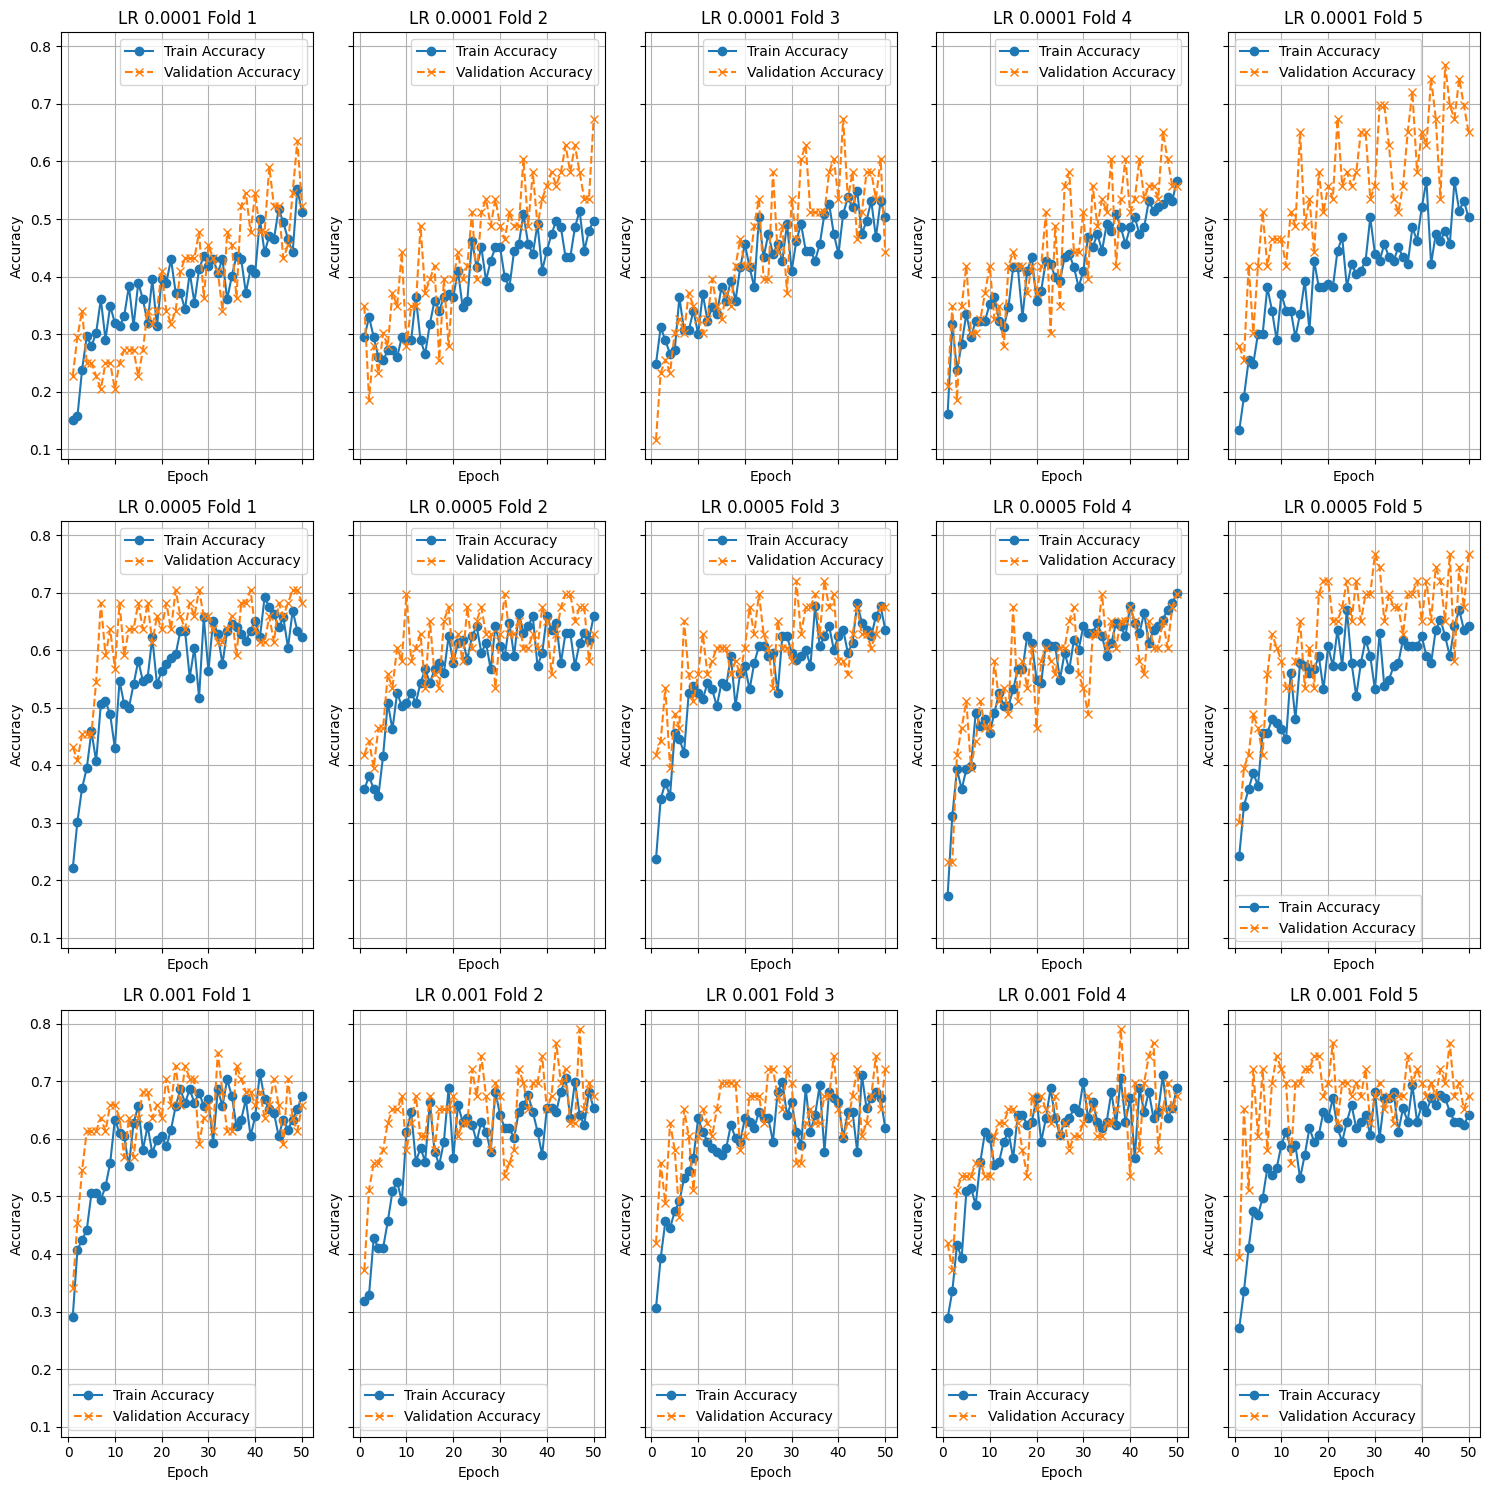

In [62]:
import matplotlib.pyplot as plt

# Unique learning rates and folds
unique_lrs = sorted(set(learning_rates))
unique_folds = sorted(set(folds))

# Number of rows and columns
num_rows = len(unique_lrs)
num_cols = len(unique_folds)

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), sharex=True, sharey=True)

# Plot data for each combination of learning rate and fold
for row_index, lr in enumerate(unique_lrs):
    for col_index, fold in enumerate(unique_folds):
        # Filter the data for the current learning rate and fold
        indices = [i for i, (l, f) in enumerate(zip(learning_rates, folds)) if l == lr and f == fold]
        epochs_filtered = [epochs[i] for i in indices]
        train_acc_filtered = [train_accuracies[i] for i in indices]
        val_acc_filtered = [val_accuracies[i] for i in indices]

        # Plot training and validation accuracies
        ax = axes[row_index][col_index]
        ax.plot(epochs_filtered, train_acc_filtered, 'o-', label='Train Accuracy')
        ax.plot(epochs_filtered, val_acc_filtered, 'x--', label='Validation Accuracy')
        ax.set_title(f'LR {lr} Fold {fold}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy')
        ax.legend()
        ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()



In [56]:
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    print("Number of GPUs Available:", num_gpus)
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available. No GPUs found.")

Number of GPUs Available: 1
GPU 0: Tesla V100-SXM2-16GB


In [17]:
from google.colab import files
uploaded = files.upload()

Saving Atlanta_supply_dat.xlsx - Atlanta_dat.csv to Atlanta_supply_dat.xlsx - Atlanta_dat.csv
Saving Atlanta_supply_dat.xlsx - UC_buildings.csv to Atlanta_supply_dat.xlsx - UC_buildings.csv


In [22]:
from sklearn.model_selection import KFold
import torch
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Subset
from torch import nn, optim
import copy
import numpy as np
from torchvision.transforms.functional import to_tensor, normalize
import warnings
warnings.filterwarnings("ignore")


def my_collate_fn(batch):
    processed_batch = [(train_transforms(img), label) for img, label in batch]
    imgs, labels = zip(*processed_batch)
    imgs = torch.stack(imgs)  # Stacks a list of tensors along a new dimension
    labels = torch.tensor(labels)
    return imgs, labels


# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=15),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.2),
    transforms.ToTensor(),
    normalize
])
val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

# Model modification function with dropout
def modified_resnet18(num_classes, dropout_probability=0.5):
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(dropout_probability),
        nn.Linear(num_ftrs, num_classes)
    )
    return model

# Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs, train_loader, val_loader):
    best_acc = 0.0
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader

            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(loader.dataset)
            epoch_acc = running_corrects.double() / len(loader.dataset)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    return model



def predict(model, dataloader):
    model.eval()  # Set model to evaluation mode
    predictions = []
    for inputs, _ in dataloader:
        inputs = inputs.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
    return predictions

def run_cross_validation_and_save_model(dataset_path, num_classes=5, num_splits=5, num_epochs=100, learning_rate=1e-3):
    dataset = datasets.ImageFolder(root=img_path)
    kfold = KFold(n_splits=num_splits, shuffle=True, random_state=42)
    best_val_acc = 0.0
    best_model_wts = None
    fold_accuracies = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset.samples)):
        print(f'Training fold {fold+1}/{num_splits} with LR {learning_rate}')
        train_subsampler = Subset(dataset, train_idx)
        val_subsampler = Subset(dataset, val_idx)

        # Apply transformations on the fly
        train_loader = DataLoader(train_subsampler, batch_size=16, shuffle=True, num_workers=2, collate_fn=my_collate_fn)
        val_loader = DataLoader(val_subsampler, batch_size=16, shuffle=False, num_workers=2, collate_fn=my_collate_fn)

        model = modified_resnet18(num_classes, 0.5).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

        trained_model = train_model(model, criterion, optimizer, scheduler, num_epochs, train_loader, val_loader)
        val_acc = evaluate_model(trained_model, val_loader)
        fold_accuracies.append(val_acc)

        # Save if this is the best model so far
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_fold = fold  # Save the fold number
            best_model_wts = copy.deepcopy(trained_model.state_dict())

    # Save the best model
    if best_model_wts is not None:
        save_dir = '/content/drive/My Drive/Datathon CBRE DSC'
        save_path = os.path.join(save_dir, 'best_model.pth')
        torch.save(best_model_wts, save_path)
        print(f"Best model saved with validation accuracy: {best_val_acc:.4f}")
    else:
        print("No model was saved. Check the training process.")

    return save_path

def evaluate_model(model, dataloader):
    model.eval()
    running_corrects = 0
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
    accuracy = running_corrects.double() / len(dataloader.dataset)
    return accuracy.item()

dataset_path = img_path
model_save_path, best_fold, fold_accuracies = run_cross_validation_and_save_model(dataset_path, num_classes=5, num_splits=5, num_epochs=100, learning_rate=1e-3)


Training fold 1/5 with LR 0.001
Epoch 1/100
train Loss: 1.6336 Acc: 0.3722
val Loss: 1.5033 Acc: 0.4000
Epoch 2/100
train Loss: 1.4357 Acc: 0.3667
val Loss: 1.4098 Acc: 0.4222
Epoch 3/100
train Loss: 1.3251 Acc: 0.4889
val Loss: 1.3095 Acc: 0.5333
Epoch 4/100
train Loss: 1.3616 Acc: 0.3889
val Loss: 1.3817 Acc: 0.4667
Epoch 5/100
train Loss: 1.1365 Acc: 0.5944
val Loss: 1.1895 Acc: 0.5111
Epoch 6/100
train Loss: 1.2283 Acc: 0.4833
val Loss: 1.3173 Acc: 0.4667
Epoch 7/100
train Loss: 1.2280 Acc: 0.5556
val Loss: 1.1048 Acc: 0.5556
Epoch 8/100
train Loss: 1.1870 Acc: 0.5778
val Loss: 1.1169 Acc: 0.5778
Epoch 9/100
train Loss: 1.0545 Acc: 0.6056
val Loss: 1.1147 Acc: 0.6000
Epoch 10/100
train Loss: 1.1376 Acc: 0.5444
val Loss: 1.0926 Acc: 0.6222
Epoch 11/100
train Loss: 1.0912 Acc: 0.5556
val Loss: 1.0463 Acc: 0.6000
Epoch 12/100
train Loss: 1.1143 Acc: 0.6056
val Loss: 1.1057 Acc: 0.6222
Epoch 13/100
train Loss: 1.1003 Acc: 0.5889
val Loss: 1.0402 Acc: 0.5556
Epoch 14/100
train Loss: 1.0

ValueError: too many values to unpack (expected 3)

In [25]:
# @title
data2 = """
Training fold 1/5 with LR 0.001
Epoch 1/100
train Loss: 1.6336 Acc: 0.3722
val Loss: 1.5033 Acc: 0.4000
Epoch 2/100
train Loss: 1.4357 Acc: 0.3667
val Loss: 1.4098 Acc: 0.4222
Epoch 3/100
train Loss: 1.3251 Acc: 0.4889
val Loss: 1.3095 Acc: 0.5333
Epoch 4/100
train Loss: 1.3616 Acc: 0.3889
val Loss: 1.3817 Acc: 0.4667
Epoch 5/100
train Loss: 1.1365 Acc: 0.5944
val Loss: 1.1895 Acc: 0.5111
Epoch 6/100
train Loss: 1.2283 Acc: 0.4833
val Loss: 1.3173 Acc: 0.4667
Epoch 7/100
train Loss: 1.2280 Acc: 0.5556
val Loss: 1.1048 Acc: 0.5556
Epoch 8/100
train Loss: 1.1870 Acc: 0.5778
val Loss: 1.1169 Acc: 0.5778
Epoch 9/100
train Loss: 1.0545 Acc: 0.6056
val Loss: 1.1147 Acc: 0.6000
Epoch 10/100
train Loss: 1.1376 Acc: 0.5444
val Loss: 1.0926 Acc: 0.6222
Epoch 11/100
train Loss: 1.0912 Acc: 0.5556
val Loss: 1.0463 Acc: 0.6000
Epoch 12/100
train Loss: 1.1143 Acc: 0.6056
val Loss: 1.1057 Acc: 0.6222
Epoch 13/100
train Loss: 1.1003 Acc: 0.5889
val Loss: 1.0402 Acc: 0.5556
Epoch 14/100
train Loss: 1.0793 Acc: 0.5722
val Loss: 1.0471 Acc: 0.6667
Epoch 15/100
train Loss: 1.0024 Acc: 0.6333
val Loss: 0.9126 Acc: 0.6667
Epoch 16/100
train Loss: 1.0521 Acc: 0.5833
val Loss: 0.9649 Acc: 0.6222
Epoch 17/100
train Loss: 0.8843 Acc: 0.6778
val Loss: 1.1107 Acc: 0.6444
Epoch 18/100
train Loss: 0.9547 Acc: 0.6444
val Loss: 0.9757 Acc: 0.6222
Epoch 19/100
train Loss: 1.0417 Acc: 0.6222
val Loss: 1.1193 Acc: 0.5556
Epoch 20/100
train Loss: 1.0183 Acc: 0.6056
val Loss: 0.8688 Acc: 0.6667
Epoch 21/100
train Loss: 1.0125 Acc: 0.5833
val Loss: 0.9884 Acc: 0.6444
Epoch 22/100
train Loss: 0.9121 Acc: 0.6667
val Loss: 0.9484 Acc: 0.7111
Epoch 23/100
train Loss: 0.9107 Acc: 0.6611
val Loss: 0.9988 Acc: 0.6000
Epoch 24/100
train Loss: 0.9278 Acc: 0.6556
val Loss: 0.9229 Acc: 0.7111
Epoch 25/100
train Loss: 1.0132 Acc: 0.5833
val Loss: 0.8855 Acc: 0.6889
Epoch 26/100
train Loss: 0.9586 Acc: 0.6389
val Loss: 0.8210 Acc: 0.7333
Epoch 27/100
train Loss: 0.8535 Acc: 0.6722
val Loss: 0.9460 Acc: 0.6889
Epoch 28/100
train Loss: 0.9566 Acc: 0.5889
val Loss: 0.9630 Acc: 0.6667
Epoch 29/100
train Loss: 1.0067 Acc: 0.6000
val Loss: 0.9060 Acc: 0.6889
Epoch 30/100
train Loss: 0.8381 Acc: 0.6611
val Loss: 0.9597 Acc: 0.6000
Epoch 31/100
train Loss: 0.8719 Acc: 0.6611
val Loss: 0.9981 Acc: 0.6222
Epoch 32/100
train Loss: 0.9158 Acc: 0.6389
val Loss: 0.8151 Acc: 0.7111
Epoch 33/100
train Loss: 1.0181 Acc: 0.5944
val Loss: 0.9476 Acc: 0.6444
Epoch 34/100
train Loss: 0.9488 Acc: 0.6389
val Loss: 0.9441 Acc: 0.6222
Epoch 35/100
train Loss: 0.8785 Acc: 0.6722
val Loss: 0.9601 Acc: 0.6444
Epoch 36/100
train Loss: 0.8764 Acc: 0.6667
val Loss: 0.9679 Acc: 0.6667
Epoch 37/100
train Loss: 0.9482 Acc: 0.6167
val Loss: 0.8682 Acc: 0.6222
Epoch 38/100
train Loss: 0.9907 Acc: 0.6278
val Loss: 0.9446 Acc: 0.6667
Epoch 39/100
train Loss: 0.8386 Acc: 0.6778
val Loss: 0.8823 Acc: 0.6222
Epoch 40/100
train Loss: 0.8245 Acc: 0.6778
val Loss: 1.0163 Acc: 0.6667
Epoch 41/100
train Loss: 1.0010 Acc: 0.6167
val Loss: 0.8869 Acc: 0.6667
Epoch 42/100
train Loss: 0.9474 Acc: 0.6278
val Loss: 1.0647 Acc: 0.5556
Epoch 43/100
train Loss: 0.8237 Acc: 0.6278
val Loss: 0.9162 Acc: 0.6667
Epoch 44/100
train Loss: 0.8634 Acc: 0.6778
val Loss: 0.8435 Acc: 0.7556
Epoch 45/100
train Loss: 0.9390 Acc: 0.6333
val Loss: 0.9064 Acc: 0.6889
Epoch 46/100
train Loss: 0.8111 Acc: 0.6556
val Loss: 0.9798 Acc: 0.6444
Epoch 47/100
train Loss: 0.8828 Acc: 0.6667
val Loss: 1.1281 Acc: 0.6444
Epoch 48/100
train Loss: 0.8985 Acc: 0.6278
val Loss: 0.7361 Acc: 0.7111
Epoch 49/100
train Loss: 0.8803 Acc: 0.6167
val Loss: 1.0691 Acc: 0.6667
Epoch 50/100
train Loss: 0.9295 Acc: 0.6722
val Loss: 0.9614 Acc: 0.6444
Epoch 51/100
train Loss: 0.8483 Acc: 0.6611
val Loss: 0.8710 Acc: 0.5778
Epoch 52/100
train Loss: 0.9214 Acc: 0.6056
val Loss: 0.9369 Acc: 0.6667
Epoch 53/100
train Loss: 0.8344 Acc: 0.6667
val Loss: 0.8035 Acc: 0.6889
Epoch 54/100
train Loss: 0.8464 Acc: 0.6889
val Loss: 0.8221 Acc: 0.7111
Epoch 55/100
train Loss: 0.9316 Acc: 0.6111
val Loss: 0.9024 Acc: 0.6889
Epoch 56/100
train Loss: 0.8315 Acc: 0.7056
val Loss: 0.7940 Acc: 0.7333
Epoch 57/100
train Loss: 0.9131 Acc: 0.6222
val Loss: 0.9588 Acc: 0.6667
Epoch 58/100
train Loss: 0.8834 Acc: 0.6444
val Loss: 0.8103 Acc: 0.7333
Epoch 59/100
train Loss: 0.8119 Acc: 0.6389
val Loss: 0.8385 Acc: 0.7333
Epoch 60/100
train Loss: 0.8408 Acc: 0.6833
val Loss: 1.0015 Acc: 0.5556
Epoch 61/100
train Loss: 0.9612 Acc: 0.6389
val Loss: 1.1251 Acc: 0.5556
Epoch 62/100
train Loss: 0.9879 Acc: 0.5944
val Loss: 1.1863 Acc: 0.5778
Epoch 63/100
train Loss: 0.8654 Acc: 0.6722
val Loss: 0.9829 Acc: 0.6000
Epoch 64/100
train Loss: 0.8080 Acc: 0.6500
val Loss: 0.8937 Acc: 0.6889
Epoch 65/100
train Loss: 0.9413 Acc: 0.6611
val Loss: 0.9611 Acc: 0.5556
Epoch 66/100
train Loss: 0.9064 Acc: 0.6500
val Loss: 0.9477 Acc: 0.6222
Epoch 67/100
train Loss: 0.8245 Acc: 0.7111
val Loss: 1.0002 Acc: 0.6444
Epoch 68/100
train Loss: 0.9075 Acc: 0.6111
val Loss: 0.9565 Acc: 0.7111
Epoch 69/100
train Loss: 0.8333 Acc: 0.7056
val Loss: 0.9744 Acc: 0.6444
Epoch 70/100
train Loss: 0.9570 Acc: 0.5889
val Loss: 0.9160 Acc: 0.6222
Epoch 71/100
train Loss: 0.8537 Acc: 0.6722
val Loss: 0.9367 Acc: 0.6444
Epoch 72/100
train Loss: 0.8853 Acc: 0.6500
val Loss: 0.8980 Acc: 0.6667
Epoch 73/100
train Loss: 0.8405 Acc: 0.6611
val Loss: 0.8207 Acc: 0.7111
Epoch 74/100
train Loss: 0.8191 Acc: 0.6500
val Loss: 0.8681 Acc: 0.6889
Epoch 75/100
train Loss: 0.7898 Acc: 0.6833
val Loss: 0.9222 Acc: 0.6222
Epoch 76/100
train Loss: 0.8354 Acc: 0.7111
val Loss: 0.9471 Acc: 0.6222
Epoch 77/100
train Loss: 1.0271 Acc: 0.6444
val Loss: 0.8052 Acc: 0.7333
Epoch 78/100
train Loss: 0.8523 Acc: 0.6500
val Loss: 0.8552 Acc: 0.7111
Epoch 79/100
train Loss: 0.8844 Acc: 0.6500
val Loss: 0.8139 Acc: 0.7333
Epoch 80/100
train Loss: 0.8798 Acc: 0.6444
val Loss: 0.8395 Acc: 0.5778
Epoch 81/100
train Loss: 0.8471 Acc: 0.6611
val Loss: 0.8127 Acc: 0.7556
Epoch 82/100
train Loss: 0.8785 Acc: 0.6667
val Loss: 1.0053 Acc: 0.5778
Epoch 83/100
train Loss: 0.8336 Acc: 0.6722
val Loss: 0.9266 Acc: 0.6222
Epoch 84/100
train Loss: 0.9022 Acc: 0.6278
val Loss: 0.9711 Acc: 0.6444
Epoch 85/100
train Loss: 0.8296 Acc: 0.6667
val Loss: 0.8692 Acc: 0.6667
Epoch 86/100
train Loss: 0.7539 Acc: 0.7111
val Loss: 0.8410 Acc: 0.7111
Epoch 87/100
train Loss: 0.9055 Acc: 0.6278
val Loss: 0.9165 Acc: 0.6444
Epoch 88/100
train Loss: 0.7540 Acc: 0.7222
val Loss: 0.7790 Acc: 0.6667
Epoch 89/100
train Loss: 0.7599 Acc: 0.7056
val Loss: 0.8571 Acc: 0.7111
Epoch 90/100
train Loss: 0.8279 Acc: 0.6611
val Loss: 1.0515 Acc: 0.5333
Epoch 91/100
train Loss: 0.8215 Acc: 0.6667
val Loss: 0.7683 Acc: 0.6444
Epoch 92/100
train Loss: 0.8066 Acc: 0.6722
val Loss: 1.0323 Acc: 0.5778
Epoch 93/100
train Loss: 0.8190 Acc: 0.6778
val Loss: 0.8087 Acc: 0.7333
Epoch 94/100
train Loss: 0.8017 Acc: 0.6778
val Loss: 0.7875 Acc: 0.6667
Epoch 95/100
train Loss: 0.8783 Acc: 0.6556
val Loss: 0.9333 Acc: 0.6889
Epoch 96/100
train Loss: 0.7885 Acc: 0.6389
val Loss: 1.0268 Acc: 0.6222
Epoch 97/100
train Loss: 0.8753 Acc: 0.6000
val Loss: 1.1326 Acc: 0.6222
Epoch 98/100
train Loss: 0.9456 Acc: 0.6444
val Loss: 0.8169 Acc: 0.6222
Epoch 99/100
train Loss: 0.7870 Acc: 0.6944
val Loss: 1.0063 Acc: 0.6222
Epoch 100/100
train Loss: 0.8279 Acc: 0.6556
val Loss: 1.0935 Acc: 0.6222
Training fold 2/5 with LR 0.001
Epoch 1/100
train Loss: 1.7428 Acc: 0.2611
val Loss: 1.2734 Acc: 0.5556
Epoch 2/100
train Loss: 1.4669 Acc: 0.3722
val Loss: 1.2394 Acc: 0.4444
Epoch 3/100
train Loss: 1.4604 Acc: 0.3889
val Loss: 1.0463 Acc: 0.6444
Epoch 4/100
train Loss: 1.5092 Acc: 0.3722
val Loss: 0.9816 Acc: 0.6222
Epoch 5/100
train Loss: 1.2346 Acc: 0.5000
val Loss: 0.9726 Acc: 0.6667
Epoch 6/100
train Loss: 1.2532 Acc: 0.5611
val Loss: 0.9154 Acc: 0.7111
Epoch 7/100
train Loss: 1.2028 Acc: 0.5222
val Loss: 0.8988 Acc: 0.6667
Epoch 8/100
train Loss: 1.2366 Acc: 0.5278
val Loss: 0.8102 Acc: 0.6889
Epoch 9/100
train Loss: 1.2550 Acc: 0.5222
val Loss: 0.9201 Acc: 0.6000
Epoch 10/100
train Loss: 1.1474 Acc: 0.5556
val Loss: 0.8145 Acc: 0.7333
Epoch 11/100
train Loss: 1.0925 Acc: 0.6000
val Loss: 0.6942 Acc: 0.7778
Epoch 12/100
train Loss: 1.2342 Acc: 0.5000
val Loss: 0.8036 Acc: 0.7556
Epoch 13/100
train Loss: 1.1335 Acc: 0.5556
val Loss: 0.8020 Acc: 0.7333
Epoch 14/100
train Loss: 1.1245 Acc: 0.5722
val Loss: 0.7981 Acc: 0.6889
Epoch 15/100
train Loss: 1.1438 Acc: 0.5500
val Loss: 0.7852 Acc: 0.7333
Epoch 16/100
train Loss: 1.0562 Acc: 0.5833
val Loss: 0.7556 Acc: 0.7333
Epoch 17/100
train Loss: 1.0086 Acc: 0.5944
val Loss: 0.7264 Acc: 0.7556
Epoch 18/100
train Loss: 1.0580 Acc: 0.5833
val Loss: 0.7793 Acc: 0.7111
Epoch 19/100
train Loss: 1.0574 Acc: 0.5778
val Loss: 0.7331 Acc: 0.7778
Epoch 20/100
train Loss: 1.0182 Acc: 0.6278
val Loss: 0.8158 Acc: 0.6889
Epoch 21/100
train Loss: 0.9600 Acc: 0.6500
val Loss: 0.5686 Acc: 0.8000
Epoch 22/100
train Loss: 1.0170 Acc: 0.6056
val Loss: 0.6750 Acc: 0.6889
Epoch 23/100
train Loss: 1.0810 Acc: 0.5778
val Loss: 0.6597 Acc: 0.8222
Epoch 24/100
train Loss: 0.9541 Acc: 0.6167
val Loss: 0.6847 Acc: 0.7556
Epoch 25/100
train Loss: 1.0301 Acc: 0.6111
val Loss: 0.7126 Acc: 0.7333
Epoch 26/100
train Loss: 1.0496 Acc: 0.6222
val Loss: 0.7372 Acc: 0.7111
Epoch 27/100
train Loss: 1.0089 Acc: 0.6000
val Loss: 0.7441 Acc: 0.7333
Epoch 28/100
train Loss: 0.9618 Acc: 0.6667
val Loss: 0.8033 Acc: 0.6222
Epoch 29/100
train Loss: 0.9751 Acc: 0.6333
val Loss: 0.7418 Acc: 0.6889
Epoch 30/100
train Loss: 0.8944 Acc: 0.6389
val Loss: 0.7551 Acc: 0.6889
Epoch 31/100
train Loss: 0.9623 Acc: 0.6222
val Loss: 0.7391 Acc: 0.6667
Epoch 32/100
train Loss: 0.9018 Acc: 0.6556
val Loss: 0.6794 Acc: 0.7333
Epoch 33/100
train Loss: 0.9709 Acc: 0.6444
val Loss: 0.7104 Acc: 0.6889
Epoch 34/100
train Loss: 0.9668 Acc: 0.6167
val Loss: 0.7753 Acc: 0.6889
Epoch 35/100
train Loss: 0.9249 Acc: 0.6611
val Loss: 0.7328 Acc: 0.6444
Epoch 36/100
train Loss: 0.9704 Acc: 0.6444
val Loss: 0.8439 Acc: 0.6667
Epoch 37/100
train Loss: 0.9593 Acc: 0.5944
val Loss: 0.5776 Acc: 0.7556
Epoch 38/100
train Loss: 1.0022 Acc: 0.5889
val Loss: 0.6283 Acc: 0.6889
Epoch 39/100
train Loss: 0.9335 Acc: 0.6500
val Loss: 0.6950 Acc: 0.6889
Epoch 40/100
train Loss: 0.8522 Acc: 0.6556
val Loss: 0.7646 Acc: 0.7333
Epoch 41/100
train Loss: 0.8833 Acc: 0.6222
val Loss: 0.7829 Acc: 0.6667
Epoch 42/100
train Loss: 0.8919 Acc: 0.6500
val Loss: 0.7008 Acc: 0.7333
Epoch 43/100
train Loss: 0.8797 Acc: 0.6611
val Loss: 0.7485 Acc: 0.6889
Epoch 44/100
train Loss: 0.8495 Acc: 0.7167
val Loss: 0.7344 Acc: 0.6889
Epoch 45/100
train Loss: 0.9629 Acc: 0.6167
val Loss: 0.7088 Acc: 0.7333
Epoch 46/100
train Loss: 0.9304 Acc: 0.6500
val Loss: 0.7604 Acc: 0.6889
Epoch 47/100
train Loss: 0.8452 Acc: 0.6889
val Loss: 0.6969 Acc: 0.7111
Epoch 48/100
train Loss: 0.9677 Acc: 0.6222
val Loss: 0.6345 Acc: 0.7333
Epoch 49/100
train Loss: 0.8995 Acc: 0.6000
val Loss: 0.7263 Acc: 0.6444
Epoch 50/100
train Loss: 0.8676 Acc: 0.6722
val Loss: 0.6894 Acc: 0.6889
Epoch 51/100
train Loss: 0.8901 Acc: 0.6333
val Loss: 0.6993 Acc: 0.6444
Epoch 52/100
train Loss: 0.9711 Acc: 0.6111
val Loss: 0.7865 Acc: 0.6000
Epoch 53/100
train Loss: 0.9235 Acc: 0.6278
val Loss: 0.7567 Acc: 0.6444
Epoch 54/100
train Loss: 0.9274 Acc: 0.6111
val Loss: 0.6616 Acc: 0.7778
Epoch 55/100
train Loss: 1.0242 Acc: 0.6222
val Loss: 0.6686 Acc: 0.7111
Epoch 56/100
train Loss: 0.8825 Acc: 0.6889
val Loss: 0.7560 Acc: 0.6667
Epoch 57/100
train Loss: 0.8635 Acc: 0.6611
val Loss: 0.7010 Acc: 0.6667
Epoch 58/100
train Loss: 0.9662 Acc: 0.5889
val Loss: 0.6871 Acc: 0.6667
Epoch 59/100
train Loss: 0.8539 Acc: 0.6333
val Loss: 0.5875 Acc: 0.8222
Epoch 60/100
train Loss: 0.9787 Acc: 0.6056
val Loss: 0.7051 Acc: 0.7111
Epoch 61/100
train Loss: 0.9145 Acc: 0.6167
val Loss: 0.6509 Acc: 0.7111
Epoch 62/100
train Loss: 0.9915 Acc: 0.6333
val Loss: 0.5739 Acc: 0.7333
Epoch 63/100
train Loss: 1.0333 Acc: 0.6500
val Loss: 0.7190 Acc: 0.7333
Epoch 64/100
train Loss: 0.9160 Acc: 0.6556
val Loss: 0.6956 Acc: 0.7111
Epoch 65/100
train Loss: 0.8809 Acc: 0.6389
val Loss: 0.7862 Acc: 0.7111
Epoch 66/100
train Loss: 0.8732 Acc: 0.6167
val Loss: 0.6944 Acc: 0.6889
Epoch 67/100
train Loss: 0.9204 Acc: 0.5944
val Loss: 0.7014 Acc: 0.7111
Epoch 68/100
train Loss: 0.9608 Acc: 0.6444
val Loss: 0.7276 Acc: 0.6444
Epoch 69/100
train Loss: 0.8533 Acc: 0.6611
val Loss: 0.7793 Acc: 0.7111
Epoch 70/100
train Loss: 0.8387 Acc: 0.6778
val Loss: 0.6727 Acc: 0.6667
Epoch 71/100
train Loss: 0.9822 Acc: 0.6500
val Loss: 0.6856 Acc: 0.6667
Epoch 72/100
train Loss: 0.8271 Acc: 0.6889
val Loss: 0.5416 Acc: 0.8222
Epoch 73/100
train Loss: 0.8351 Acc: 0.6778
val Loss: 0.6196 Acc: 0.7111
Epoch 74/100
train Loss: 0.9047 Acc: 0.6278
val Loss: 0.6699 Acc: 0.7333
Epoch 75/100
train Loss: 0.9862 Acc: 0.5944
val Loss: 0.6084 Acc: 0.6667
Epoch 76/100
train Loss: 0.9064 Acc: 0.6389
val Loss: 0.6348 Acc: 0.7556
Epoch 77/100
train Loss: 0.8474 Acc: 0.6556
val Loss: 0.6780 Acc: 0.7333
Epoch 78/100
train Loss: 0.8372 Acc: 0.6944
val Loss: 0.6457 Acc: 0.7333
Epoch 79/100
train Loss: 0.9331 Acc: 0.6111
val Loss: 0.6880 Acc: 0.6222
Epoch 80/100
train Loss: 0.9217 Acc: 0.6500
val Loss: 0.6111 Acc: 0.7333
Epoch 81/100
train Loss: 0.8847 Acc: 0.6722
val Loss: 0.6933 Acc: 0.6667
Epoch 82/100
train Loss: 0.7058 Acc: 0.7444
val Loss: 0.6961 Acc: 0.7111
Epoch 83/100
train Loss: 0.9347 Acc: 0.6000
val Loss: 0.6188 Acc: 0.6667
Epoch 84/100
train Loss: 0.8882 Acc: 0.6667
val Loss: 0.6727 Acc: 0.7556
Epoch 85/100
train Loss: 0.8138 Acc: 0.6889
val Loss: 0.6040 Acc: 0.8000
Epoch 86/100
train Loss: 0.9120 Acc: 0.6389
val Loss: 0.7081 Acc: 0.6000
Epoch 87/100
train Loss: 0.9070 Acc: 0.6667
val Loss: 0.7552 Acc: 0.6889
Epoch 88/100
train Loss: 1.0133 Acc: 0.6278
val Loss: 0.5893 Acc: 0.7556
Epoch 89/100
train Loss: 0.8231 Acc: 0.6611
val Loss: 0.6957 Acc: 0.6667
Epoch 90/100
train Loss: 0.8745 Acc: 0.6778
val Loss: 0.7195 Acc: 0.6222
Epoch 91/100
train Loss: 0.8680 Acc: 0.6778
val Loss: 0.7648 Acc: 0.6889
Epoch 92/100
train Loss: 1.0297 Acc: 0.6056
val Loss: 0.6639 Acc: 0.6444
Epoch 93/100
train Loss: 0.8496 Acc: 0.6389
val Loss: 0.7641 Acc: 0.7111
Epoch 94/100
train Loss: 0.8765 Acc: 0.6944
val Loss: 0.6364 Acc: 0.7333
Epoch 95/100
train Loss: 0.8430 Acc: 0.6333
val Loss: 0.5975 Acc: 0.7556
Epoch 96/100
train Loss: 0.8710 Acc: 0.6722
val Loss: 0.6359 Acc: 0.7111
Epoch 97/100
train Loss: 0.9178 Acc: 0.6611
val Loss: 0.6545 Acc: 0.7333
Epoch 98/100
train Loss: 0.8833 Acc: 0.6389
val Loss: 0.6675 Acc: 0.6889
Epoch 99/100
train Loss: 0.7682 Acc: 0.6944
val Loss: 0.6698 Acc: 0.7333
Epoch 100/100
train Loss: 0.9483 Acc: 0.6667
val Loss: 0.7024 Acc: 0.6667
Training fold 3/5 with LR 0.001
Epoch 1/100
train Loss: 1.6589 Acc: 0.3333
val Loss: 1.6051 Acc: 0.3333
Epoch 2/100
train Loss: 1.5525 Acc: 0.3444
val Loss: 1.5276 Acc: 0.3556
Epoch 3/100
train Loss: 1.4196 Acc: 0.4611
val Loss: 1.4127 Acc: 0.4889
Epoch 4/100
train Loss: 1.3460 Acc: 0.4444
val Loss: 1.2467 Acc: 0.5333
Epoch 5/100
train Loss: 1.2992 Acc: 0.4611
val Loss: 1.3611 Acc: 0.4444
Epoch 6/100
train Loss: 1.3115 Acc: 0.4444
val Loss: 1.2198 Acc: 0.6000
Epoch 7/100
train Loss: 1.2360 Acc: 0.5000
val Loss: 1.2823 Acc: 0.5333
Epoch 8/100
train Loss: 1.2096 Acc: 0.4722
val Loss: 1.1874 Acc: 0.5778
Epoch 9/100
train Loss: 1.1601 Acc: 0.5611
val Loss: 1.1691 Acc: 0.6222
Epoch 10/100
train Loss: 1.1010 Acc: 0.5889
val Loss: 1.2125 Acc: 0.4889
Epoch 11/100
train Loss: 1.1152 Acc: 0.5278
val Loss: 1.0922 Acc: 0.6000
Epoch 12/100
train Loss: 1.1347 Acc: 0.5667
val Loss: 1.0826 Acc: 0.6222
Epoch 13/100
train Loss: 1.1046 Acc: 0.5444
val Loss: 1.1315 Acc: 0.5778
Epoch 14/100
train Loss: 1.0744 Acc: 0.5833
val Loss: 1.1265 Acc: 0.5778
Epoch 15/100
train Loss: 1.0150 Acc: 0.6111
val Loss: 1.1877 Acc: 0.5778
Epoch 16/100
train Loss: 0.9714 Acc: 0.6167
val Loss: 1.2320 Acc: 0.6000
Epoch 17/100
train Loss: 0.9869 Acc: 0.5889
val Loss: 1.1242 Acc: 0.6222
Epoch 18/100
train Loss: 1.0269 Acc: 0.5889
val Loss: 1.1018 Acc: 0.6000
Epoch 19/100
train Loss: 0.9798 Acc: 0.6056
val Loss: 1.1431 Acc: 0.6000
Epoch 20/100
train Loss: 0.9699 Acc: 0.6056
val Loss: 1.0696 Acc: 0.5778
Epoch 21/100
train Loss: 0.9559 Acc: 0.6500
val Loss: 1.0706 Acc: 0.6222
Epoch 22/100
train Loss: 1.0426 Acc: 0.5944
val Loss: 1.0772 Acc: 0.6222
Epoch 23/100
train Loss: 0.9935 Acc: 0.5889
val Loss: 1.0814 Acc: 0.5778
Epoch 24/100
train Loss: 0.8646 Acc: 0.6611
val Loss: 1.0694 Acc: 0.6889
Epoch 25/100
train Loss: 0.9472 Acc: 0.6444
val Loss: 1.0767 Acc: 0.6000
Epoch 26/100
train Loss: 0.9230 Acc: 0.6389
val Loss: 1.0627 Acc: 0.6222
Epoch 27/100
train Loss: 0.8920 Acc: 0.6500
val Loss: 1.1650 Acc: 0.5111
Epoch 28/100
train Loss: 0.9407 Acc: 0.6889
val Loss: 1.0931 Acc: 0.6889
Epoch 29/100
train Loss: 0.8857 Acc: 0.6444
val Loss: 1.0268 Acc: 0.6222
Epoch 30/100
train Loss: 0.7975 Acc: 0.7111
val Loss: 1.0446 Acc: 0.6444
Epoch 31/100
train Loss: 0.8647 Acc: 0.6722
val Loss: 1.1274 Acc: 0.6000
Epoch 32/100
train Loss: 0.8598 Acc: 0.6444
val Loss: 1.1060 Acc: 0.5556
Epoch 33/100
train Loss: 0.8762 Acc: 0.6667
val Loss: 1.0237 Acc: 0.6222
Epoch 34/100
train Loss: 0.8482 Acc: 0.6667
val Loss: 1.0368 Acc: 0.6000
Epoch 35/100
train Loss: 0.8407 Acc: 0.7000
val Loss: 1.0339 Acc: 0.6444
Epoch 36/100
train Loss: 0.8643 Acc: 0.6611
val Loss: 0.9530 Acc: 0.6222
Epoch 37/100
train Loss: 0.8795 Acc: 0.6778
val Loss: 1.0872 Acc: 0.5778
Epoch 38/100
train Loss: 0.8666 Acc: 0.6722
val Loss: 1.1808 Acc: 0.6000
Epoch 39/100
train Loss: 0.8810 Acc: 0.6556
val Loss: 1.0317 Acc: 0.6444
Epoch 40/100
train Loss: 0.9610 Acc: 0.6389
val Loss: 0.9711 Acc: 0.6000
Epoch 41/100
train Loss: 0.8862 Acc: 0.6833
val Loss: 1.1240 Acc: 0.6667
Epoch 42/100
train Loss: 0.8655 Acc: 0.6611
val Loss: 1.0347 Acc: 0.6667
Epoch 43/100
train Loss: 0.8593 Acc: 0.7000
val Loss: 1.2072 Acc: 0.5556
Epoch 44/100
train Loss: 0.9650 Acc: 0.6611
val Loss: 1.0396 Acc: 0.6667
Epoch 45/100
train Loss: 0.7878 Acc: 0.6944
val Loss: 1.0939 Acc: 0.5778
Epoch 46/100
train Loss: 0.8543 Acc: 0.6667
val Loss: 1.0006 Acc: 0.6444
Epoch 47/100
train Loss: 0.8384 Acc: 0.6333
val Loss: 1.0629 Acc: 0.6667
Epoch 48/100
train Loss: 0.8577 Acc: 0.6778
val Loss: 1.1097 Acc: 0.5556
Epoch 49/100
train Loss: 0.9022 Acc: 0.6222
val Loss: 1.1354 Acc: 0.6444
Epoch 50/100
train Loss: 0.9772 Acc: 0.6389
val Loss: 1.0971 Acc: 0.5778
Epoch 51/100
train Loss: 0.7967 Acc: 0.6833
val Loss: 1.0309 Acc: 0.5556
Epoch 52/100
train Loss: 0.8398 Acc: 0.6889
val Loss: 1.0067 Acc: 0.6667
Epoch 53/100
train Loss: 0.8429 Acc: 0.6278
val Loss: 1.2167 Acc: 0.6000
Epoch 54/100
train Loss: 0.8575 Acc: 0.6278
val Loss: 1.0797 Acc: 0.6889
Epoch 55/100
train Loss: 0.7595 Acc: 0.7444
val Loss: 1.0798 Acc: 0.5333
Epoch 56/100
train Loss: 0.9752 Acc: 0.5778
val Loss: 1.1518 Acc: 0.6444
Epoch 57/100
train Loss: 0.8181 Acc: 0.6556
val Loss: 1.1122 Acc: 0.5333
Epoch 58/100
train Loss: 0.8697 Acc: 0.6444
val Loss: 1.0165 Acc: 0.6667
Epoch 59/100
train Loss: 0.8951 Acc: 0.6167
val Loss: 1.1500 Acc: 0.6222
Epoch 60/100
train Loss: 0.8176 Acc: 0.6667
val Loss: 1.0986 Acc: 0.5556
Epoch 61/100
train Loss: 0.7987 Acc: 0.6944
val Loss: 1.0673 Acc: 0.5333
Epoch 62/100
train Loss: 0.8698 Acc: 0.6833
val Loss: 0.9476 Acc: 0.6667
Epoch 63/100
train Loss: 0.7929 Acc: 0.6500
val Loss: 0.9355 Acc: 0.6000
Epoch 64/100
train Loss: 0.7725 Acc: 0.6778
val Loss: 1.1320 Acc: 0.6444
Epoch 65/100
train Loss: 0.9352 Acc: 0.6667
val Loss: 1.0275 Acc: 0.6000
Epoch 66/100
train Loss: 0.8505 Acc: 0.6556
val Loss: 1.0315 Acc: 0.6444
Epoch 67/100
train Loss: 0.8052 Acc: 0.7000
val Loss: 0.9946 Acc: 0.5778
Epoch 68/100
train Loss: 0.8863 Acc: 0.6667
val Loss: 1.1964 Acc: 0.6000
Epoch 69/100
train Loss: 0.9277 Acc: 0.6556
val Loss: 1.0107 Acc: 0.6444
Epoch 70/100
train Loss: 0.8035 Acc: 0.7000
val Loss: 1.1247 Acc: 0.6444
Epoch 71/100
train Loss: 0.8054 Acc: 0.6778
val Loss: 1.0064 Acc: 0.6222
Epoch 72/100
train Loss: 0.8271 Acc: 0.6556
val Loss: 1.0669 Acc: 0.6444
Epoch 73/100
train Loss: 0.8471 Acc: 0.6611
val Loss: 1.0895 Acc: 0.5778
Epoch 74/100
train Loss: 0.8915 Acc: 0.7167
val Loss: 1.0881 Acc: 0.6444
Epoch 75/100
train Loss: 0.8281 Acc: 0.6556
val Loss: 1.1837 Acc: 0.5778
Epoch 76/100
train Loss: 0.7955 Acc: 0.6889
val Loss: 1.1127 Acc: 0.6444
Epoch 77/100
train Loss: 0.8877 Acc: 0.6833
val Loss: 1.1802 Acc: 0.5556
Epoch 78/100
train Loss: 0.8018 Acc: 0.7000
val Loss: 1.0609 Acc: 0.6889
Epoch 79/100
train Loss: 0.7884 Acc: 0.7056
val Loss: 1.1865 Acc: 0.6000
Epoch 80/100
train Loss: 0.8182 Acc: 0.6778
val Loss: 1.2220 Acc: 0.6444
Epoch 81/100
train Loss: 0.7527 Acc: 0.7222
val Loss: 1.2785 Acc: 0.5556
Epoch 82/100
train Loss: 0.9193 Acc: 0.6056
val Loss: 1.0777 Acc: 0.6667
Epoch 83/100
train Loss: 0.8204 Acc: 0.6500
val Loss: 1.1067 Acc: 0.6000
Epoch 84/100
train Loss: 0.8220 Acc: 0.7056
val Loss: 1.0896 Acc: 0.6222
Epoch 85/100
train Loss: 0.8100 Acc: 0.6944
val Loss: 1.2514 Acc: 0.6000
Epoch 86/100
train Loss: 0.8528 Acc: 0.6389
val Loss: 1.3235 Acc: 0.5556
Epoch 87/100
train Loss: 0.8301 Acc: 0.7000
val Loss: 1.1098 Acc: 0.6222
Epoch 88/100
train Loss: 0.7576 Acc: 0.7000
val Loss: 1.0144 Acc: 0.5778
Epoch 89/100
train Loss: 0.9009 Acc: 0.6444
val Loss: 1.1476 Acc: 0.6444
Epoch 90/100
train Loss: 0.8175 Acc: 0.6833
val Loss: 1.0440 Acc: 0.5111
Epoch 91/100
train Loss: 0.8056 Acc: 0.7111
val Loss: 1.0758 Acc: 0.6222
Epoch 92/100
train Loss: 0.7942 Acc: 0.6889
val Loss: 1.1053 Acc: 0.6000
Epoch 93/100
train Loss: 0.7939 Acc: 0.6667
val Loss: 1.1137 Acc: 0.5778
Epoch 94/100
train Loss: 0.8437 Acc: 0.6722
val Loss: 1.0043 Acc: 0.6889
Epoch 95/100
train Loss: 0.7497 Acc: 0.7167
val Loss: 1.0873 Acc: 0.6222
Epoch 96/100
train Loss: 0.8734 Acc: 0.6722
val Loss: 0.9453 Acc: 0.5333
Epoch 97/100
train Loss: 0.8213 Acc: 0.6500
val Loss: 1.0719 Acc: 0.6667
Epoch 98/100
train Loss: 0.9848 Acc: 0.6389
val Loss: 0.9825 Acc: 0.6000
Epoch 99/100
train Loss: 0.8848 Acc: 0.6667
val Loss: 1.0716 Acc: 0.6667
Epoch 100/100
train Loss: 0.7498 Acc: 0.7000
val Loss: 1.1486 Acc: 0.6222
Training fold 4/5 with LR 0.001
Epoch 1/100
train Loss: 1.7442 Acc: 0.3278
val Loss: 1.6693 Acc: 0.2444
Epoch 2/100
train Loss: 1.4890 Acc: 0.3833
val Loss: 1.4953 Acc: 0.3333
Epoch 3/100
train Loss: 1.4800 Acc: 0.3722
val Loss: 1.2906 Acc: 0.4889
Epoch 4/100
train Loss: 1.3987 Acc: 0.4444
val Loss: 1.3229 Acc: 0.5333
Epoch 5/100
train Loss: 1.3827 Acc: 0.4444
val Loss: 1.3056 Acc: 0.5556
Epoch 6/100
train Loss: 1.2989 Acc: 0.5111
val Loss: 1.2369 Acc: 0.4889
Epoch 7/100
train Loss: 1.2290 Acc: 0.6000
val Loss: 1.1842 Acc: 0.5111
Epoch 8/100
train Loss: 1.1495 Acc: 0.5722
val Loss: 1.1869 Acc: 0.5333
Epoch 9/100
train Loss: 1.1749 Acc: 0.5389
val Loss: 1.0783 Acc: 0.6000
Epoch 10/100
train Loss: 1.1317 Acc: 0.5556
val Loss: 1.1239 Acc: 0.6222
Epoch 11/100
train Loss: 1.1075 Acc: 0.5722
val Loss: 1.0532 Acc: 0.6222
Epoch 12/100
train Loss: 1.1368 Acc: 0.5833
val Loss: 0.9443 Acc: 0.6667
Epoch 13/100
train Loss: 1.0619 Acc: 0.6278
val Loss: 1.0075 Acc: 0.5556
Epoch 14/100
train Loss: 1.1218 Acc: 0.5722
val Loss: 0.9969 Acc: 0.6222
Epoch 15/100
train Loss: 1.0802 Acc: 0.5500
val Loss: 0.9436 Acc: 0.7111
Epoch 16/100
train Loss: 1.0076 Acc: 0.6056
val Loss: 1.0078 Acc: 0.6444
Epoch 17/100
train Loss: 0.9786 Acc: 0.5889
val Loss: 0.9281 Acc: 0.6222
Epoch 18/100
train Loss: 0.9679 Acc: 0.6222
val Loss: 1.0071 Acc: 0.6000
Epoch 19/100
train Loss: 1.0116 Acc: 0.5889
val Loss: 0.9746 Acc: 0.6667
Epoch 20/100
train Loss: 1.0096 Acc: 0.5944
val Loss: 0.9732 Acc: 0.6222
Epoch 21/100
train Loss: 0.9953 Acc: 0.6000
val Loss: 1.0099 Acc: 0.6222
Epoch 22/100
train Loss: 0.9699 Acc: 0.6278
val Loss: 0.9697 Acc: 0.6444
Epoch 23/100
train Loss: 1.1021 Acc: 0.5556
val Loss: 0.8400 Acc: 0.7111
Epoch 24/100
train Loss: 1.0412 Acc: 0.6111
val Loss: 0.8833 Acc: 0.6667
Epoch 25/100
train Loss: 0.9233 Acc: 0.6667
val Loss: 1.0732 Acc: 0.6444
Epoch 26/100
train Loss: 0.8376 Acc: 0.7000
val Loss: 0.8061 Acc: 0.7333
Epoch 27/100
train Loss: 0.9696 Acc: 0.6444
val Loss: 0.9775 Acc: 0.6667
Epoch 28/100
train Loss: 0.9766 Acc: 0.6278
val Loss: 0.9639 Acc: 0.7111
Epoch 29/100
train Loss: 1.0822 Acc: 0.6278
val Loss: 0.9052 Acc: 0.6444
Epoch 30/100
train Loss: 0.9082 Acc: 0.6333
val Loss: 0.9032 Acc: 0.6889
Epoch 31/100
train Loss: 0.8317 Acc: 0.6722
val Loss: 1.0266 Acc: 0.6222
Epoch 32/100
train Loss: 0.9517 Acc: 0.6278
val Loss: 0.9189 Acc: 0.6889
Epoch 33/100
train Loss: 0.8933 Acc: 0.7000
val Loss: 0.9333 Acc: 0.6444
Epoch 34/100
train Loss: 0.8859 Acc: 0.6722
val Loss: 0.9018 Acc: 0.6667
Epoch 35/100
train Loss: 0.9069 Acc: 0.6111
val Loss: 1.0012 Acc: 0.6444
Epoch 36/100
train Loss: 1.0882 Acc: 0.5722
val Loss: 0.8565 Acc: 0.6667
Epoch 37/100
train Loss: 0.8725 Acc: 0.6722
val Loss: 0.9978 Acc: 0.5778
Epoch 38/100
train Loss: 1.0230 Acc: 0.6056
val Loss: 0.9254 Acc: 0.6889
Epoch 39/100
train Loss: 0.9272 Acc: 0.6167
val Loss: 0.7251 Acc: 0.8000
Epoch 40/100
train Loss: 0.8870 Acc: 0.6444
val Loss: 0.8068 Acc: 0.7778
Epoch 41/100
train Loss: 0.8973 Acc: 0.6444
val Loss: 0.8986 Acc: 0.6889
Epoch 42/100
train Loss: 1.0005 Acc: 0.5944
val Loss: 0.9112 Acc: 0.7333
Epoch 43/100
train Loss: 0.8641 Acc: 0.6722
val Loss: 0.7738 Acc: 0.7111
Epoch 44/100
train Loss: 0.9138 Acc: 0.6222
val Loss: 0.8628 Acc: 0.7333
Epoch 45/100
train Loss: 0.9071 Acc: 0.6278
val Loss: 0.8589 Acc: 0.6667
Epoch 46/100
train Loss: 0.9104 Acc: 0.6556
val Loss: 0.9186 Acc: 0.6444
Epoch 47/100
train Loss: 0.9192 Acc: 0.6778
val Loss: 0.8748 Acc: 0.6667
Epoch 48/100
train Loss: 0.9150 Acc: 0.6444
val Loss: 0.8569 Acc: 0.6889
Epoch 49/100
train Loss: 0.9604 Acc: 0.6167
val Loss: 0.9300 Acc: 0.6222
Epoch 50/100
train Loss: 0.7719 Acc: 0.7167
val Loss: 0.8756 Acc: 0.6444
Epoch 51/100
train Loss: 0.8835 Acc: 0.6833
val Loss: 0.9538 Acc: 0.6667
Epoch 52/100
train Loss: 0.9118 Acc: 0.6500
val Loss: 0.8538 Acc: 0.7333
Epoch 53/100
train Loss: 0.8899 Acc: 0.6278
val Loss: 0.9199 Acc: 0.6667
Epoch 54/100
train Loss: 0.9188 Acc: 0.6222
val Loss: 0.8052 Acc: 0.7333
Epoch 55/100
train Loss: 0.8300 Acc: 0.7111
val Loss: 0.8456 Acc: 0.7556
Epoch 56/100
train Loss: 0.9239 Acc: 0.6389
val Loss: 0.9501 Acc: 0.6444
Epoch 57/100
train Loss: 0.8829 Acc: 0.6222
val Loss: 0.9711 Acc: 0.7111
Epoch 58/100
train Loss: 0.8336 Acc: 0.6500
val Loss: 0.9168 Acc: 0.7111
Epoch 59/100
train Loss: 0.9254 Acc: 0.6389
val Loss: 0.8865 Acc: 0.6889
Epoch 60/100
train Loss: 0.9390 Acc: 0.6056
val Loss: 0.9329 Acc: 0.6667
Epoch 61/100
train Loss: 0.8434 Acc: 0.6556
val Loss: 0.8542 Acc: 0.6889
Epoch 62/100
train Loss: 0.8352 Acc: 0.6944
val Loss: 0.6997 Acc: 0.8000
Epoch 63/100
train Loss: 0.9525 Acc: 0.5833
val Loss: 0.8674 Acc: 0.6889
Epoch 64/100
train Loss: 0.9088 Acc: 0.6389
val Loss: 0.8255 Acc: 0.7556
Epoch 65/100
train Loss: 0.9427 Acc: 0.6611
val Loss: 0.9656 Acc: 0.6889
Epoch 66/100
train Loss: 0.8221 Acc: 0.6778
val Loss: 0.7674 Acc: 0.7333
Epoch 67/100
train Loss: 0.8124 Acc: 0.6500
val Loss: 1.1129 Acc: 0.6444
Epoch 68/100
train Loss: 0.8445 Acc: 0.6722
val Loss: 0.8719 Acc: 0.7556
Epoch 69/100
train Loss: 0.8460 Acc: 0.6278
val Loss: 0.6701 Acc: 0.7778
Epoch 70/100
train Loss: 0.9174 Acc: 0.6611
val Loss: 0.8925 Acc: 0.6444
Epoch 71/100
train Loss: 0.7512 Acc: 0.6889
val Loss: 0.8515 Acc: 0.6889
Epoch 72/100
train Loss: 0.8716 Acc: 0.6611
val Loss: 1.0481 Acc: 0.6000
Epoch 73/100
train Loss: 0.7327 Acc: 0.7389
val Loss: 0.8419 Acc: 0.6444
Epoch 74/100
train Loss: 0.7873 Acc: 0.6556
val Loss: 0.7989 Acc: 0.7333
Epoch 75/100
train Loss: 0.8905 Acc: 0.6556
val Loss: 0.9188 Acc: 0.6889
Epoch 76/100
train Loss: 0.8778 Acc: 0.6389
val Loss: 1.0222 Acc: 0.6000
Epoch 77/100
train Loss: 0.8309 Acc: 0.6556
val Loss: 0.8534 Acc: 0.7333
Epoch 78/100
train Loss: 0.8020 Acc: 0.7056
val Loss: 0.8124 Acc: 0.6667
Epoch 79/100
train Loss: 0.8815 Acc: 0.6222
val Loss: 0.8711 Acc: 0.7111
Epoch 80/100
train Loss: 0.8341 Acc: 0.6944
val Loss: 1.0175 Acc: 0.6444
Epoch 81/100
train Loss: 0.8584 Acc: 0.6667
val Loss: 0.9311 Acc: 0.6222
Epoch 82/100
train Loss: 0.9199 Acc: 0.6111
val Loss: 0.8432 Acc: 0.7333
Epoch 83/100
train Loss: 0.9474 Acc: 0.6222
val Loss: 0.8727 Acc: 0.6889
Epoch 84/100
train Loss: 0.8643 Acc: 0.6222
val Loss: 0.8994 Acc: 0.6889
Epoch 85/100
train Loss: 0.8679 Acc: 0.6556
val Loss: 0.8817 Acc: 0.6889
Epoch 86/100
train Loss: 0.8564 Acc: 0.6556
val Loss: 0.9334 Acc: 0.7778
Epoch 87/100
train Loss: 0.8821 Acc: 0.6278
val Loss: 0.9700 Acc: 0.6667
Epoch 88/100
train Loss: 0.8637 Acc: 0.6667
val Loss: 0.8557 Acc: 0.6889
Epoch 89/100
train Loss: 0.9402 Acc: 0.6111
val Loss: 1.0731 Acc: 0.6444
Epoch 90/100
train Loss: 0.8740 Acc: 0.6500
val Loss: 0.9366 Acc: 0.6889
Epoch 91/100
train Loss: 0.8830 Acc: 0.6444
val Loss: 0.9972 Acc: 0.6222
Epoch 92/100
train Loss: 0.9350 Acc: 0.6333
val Loss: 0.7675 Acc: 0.7556
Epoch 93/100
train Loss: 0.8022 Acc: 0.7111
val Loss: 0.8186 Acc: 0.6889
Epoch 94/100
train Loss: 0.8090 Acc: 0.6611
val Loss: 1.0075 Acc: 0.6222
Epoch 95/100
train Loss: 0.7903 Acc: 0.6944
val Loss: 0.8411 Acc: 0.7556
Epoch 96/100
train Loss: 0.7645 Acc: 0.7167
val Loss: 0.8598 Acc: 0.7556
Epoch 97/100
train Loss: 0.8339 Acc: 0.6667
val Loss: 0.8983 Acc: 0.6000
Epoch 98/100
train Loss: 0.8127 Acc: 0.6556
val Loss: 0.8306 Acc: 0.6444
Epoch 99/100
train Loss: 0.9792 Acc: 0.5833
val Loss: 0.9331 Acc: 0.6222
Epoch 100/100
train Loss: 0.9893 Acc: 0.6500
val Loss: 0.7758 Acc: 0.6889
Training fold 5/5 with LR 0.001
Epoch 1/100
train Loss: 1.7488 Acc: 0.2889
val Loss: 1.5466 Acc: 0.3333
Epoch 2/100
train Loss: 1.5878 Acc: 0.3222
val Loss: 1.3684 Acc: 0.5556
Epoch 3/100
train Loss: 1.5215 Acc: 0.3556
val Loss: 1.3198 Acc: 0.4667
Epoch 4/100
train Loss: 1.2627 Acc: 0.5000
val Loss: 1.2250 Acc: 0.6000
Epoch 5/100
train Loss: 1.3022 Acc: 0.4667
val Loss: 1.1127 Acc: 0.6889
Epoch 6/100
train Loss: 1.2647 Acc: 0.4778
val Loss: 1.1682 Acc: 0.6000
Epoch 7/100
train Loss: 1.2078 Acc: 0.5167
val Loss: 1.0582 Acc: 0.6667
Epoch 8/100
train Loss: 1.2333 Acc: 0.5556
val Loss: 1.0135 Acc: 0.6444
Epoch 9/100
train Loss: 1.1689 Acc: 0.5278
val Loss: 1.0022 Acc: 0.6889
Epoch 10/100
train Loss: 1.1750 Acc: 0.5333
val Loss: 1.0450 Acc: 0.6000
Epoch 11/100
train Loss: 1.0961 Acc: 0.5889
val Loss: 1.0476 Acc: 0.7111
Epoch 12/100
train Loss: 1.1710 Acc: 0.5000
val Loss: 0.9095 Acc: 0.7111
Epoch 13/100
train Loss: 1.0187 Acc: 0.6000
val Loss: 0.9814 Acc: 0.6667
Epoch 14/100
train Loss: 1.1029 Acc: 0.6056
val Loss: 0.9695 Acc: 0.7111
Epoch 15/100
train Loss: 1.1063 Acc: 0.5389
val Loss: 0.9035 Acc: 0.6889
Epoch 16/100
train Loss: 1.0481 Acc: 0.5778
val Loss: 1.0689 Acc: 0.6000
Epoch 17/100
train Loss: 0.9878 Acc: 0.6278
val Loss: 0.9030 Acc: 0.6444
Epoch 18/100
train Loss: 1.0909 Acc: 0.6111
val Loss: 0.9290 Acc: 0.6222
Epoch 19/100
train Loss: 0.9640 Acc: 0.6611
val Loss: 0.9168 Acc: 0.6667
Epoch 20/100
train Loss: 1.0082 Acc: 0.6556
val Loss: 0.9302 Acc: 0.6222
Epoch 21/100
train Loss: 1.0071 Acc: 0.6278
val Loss: 0.8795 Acc: 0.7111
Epoch 22/100
train Loss: 0.9818 Acc: 0.6222
val Loss: 0.8779 Acc: 0.6667
Epoch 23/100
train Loss: 0.9525 Acc: 0.6333
val Loss: 0.8628 Acc: 0.7333
Epoch 24/100
train Loss: 1.1071 Acc: 0.5167
val Loss: 0.8887 Acc: 0.7111
Epoch 25/100
train Loss: 1.0899 Acc: 0.5778
val Loss: 0.9311 Acc: 0.6444
Epoch 26/100
train Loss: 1.0068 Acc: 0.6056
val Loss: 0.9214 Acc: 0.6667
Epoch 27/100
train Loss: 1.0477 Acc: 0.5722
val Loss: 0.8378 Acc: 0.6444
Epoch 28/100
train Loss: 1.0646 Acc: 0.5833
val Loss: 0.7946 Acc: 0.7111
Epoch 29/100
train Loss: 1.0260 Acc: 0.6000
val Loss: 0.9628 Acc: 0.6667
Epoch 30/100
train Loss: 0.9173 Acc: 0.6056
val Loss: 0.8881 Acc: 0.6889
Epoch 31/100
train Loss: 1.0152 Acc: 0.5889
val Loss: 0.8673 Acc: 0.7333
Epoch 32/100
train Loss: 1.0173 Acc: 0.6278
val Loss: 0.8415 Acc: 0.7333
Epoch 33/100
train Loss: 1.0333 Acc: 0.6222
val Loss: 0.7414 Acc: 0.7556
Epoch 34/100
train Loss: 1.0731 Acc: 0.5944
val Loss: 0.8630 Acc: 0.7333
Epoch 35/100
train Loss: 0.8595 Acc: 0.6611
val Loss: 0.7854 Acc: 0.7778
Epoch 36/100
train Loss: 0.9036 Acc: 0.6500
val Loss: 0.7854 Acc: 0.8000
Epoch 37/100
train Loss: 1.0453 Acc: 0.6111
val Loss: 0.8180 Acc: 0.6889
Epoch 38/100
train Loss: 0.9363 Acc: 0.5944
val Loss: 0.8256 Acc: 0.7333
Epoch 39/100
train Loss: 0.9321 Acc: 0.6167
val Loss: 0.7854 Acc: 0.7333
Epoch 40/100
train Loss: 0.8229 Acc: 0.6611
val Loss: 0.7955 Acc: 0.7333
Epoch 41/100
train Loss: 0.9690 Acc: 0.5778
val Loss: 0.8795 Acc: 0.6889
Epoch 42/100
train Loss: 0.8711 Acc: 0.7056
val Loss: 0.7887 Acc: 0.7333
Epoch 43/100
train Loss: 0.9372 Acc: 0.6389
val Loss: 0.9435 Acc: 0.6444
Epoch 44/100
train Loss: 0.9109 Acc: 0.6556
val Loss: 0.6964 Acc: 0.7333
Epoch 45/100
train Loss: 0.8507 Acc: 0.6444
val Loss: 0.7629 Acc: 0.7778
Epoch 46/100
train Loss: 1.0108 Acc: 0.5611
val Loss: 0.8957 Acc: 0.7111
Epoch 47/100
train Loss: 0.8110 Acc: 0.6889
val Loss: 0.9535 Acc: 0.7333
Epoch 48/100
train Loss: 0.8709 Acc: 0.6944
val Loss: 0.7761 Acc: 0.7111
Epoch 49/100
train Loss: 0.8455 Acc: 0.6444
val Loss: 0.8490 Acc: 0.6444
Epoch 50/100
train Loss: 0.8742 Acc: 0.6556
val Loss: 0.8322 Acc: 0.6889
Epoch 51/100
train Loss: 0.9072 Acc: 0.6444
val Loss: 0.8871 Acc: 0.6889
Epoch 52/100
train Loss: 0.8389 Acc: 0.6611
val Loss: 0.7300 Acc: 0.7333
Epoch 53/100
train Loss: 0.9743 Acc: 0.6000
val Loss: 0.8058 Acc: 0.6889
Epoch 54/100
train Loss: 0.9535 Acc: 0.6111
val Loss: 0.8127 Acc: 0.7111
Epoch 55/100
train Loss: 0.9796 Acc: 0.6222
val Loss: 0.7599 Acc: 0.7333
Epoch 56/100
train Loss: 0.9129 Acc: 0.6556
val Loss: 0.8350 Acc: 0.7556
Epoch 57/100
train Loss: 0.7842 Acc: 0.6778
val Loss: 0.8121 Acc: 0.7111
Epoch 58/100
train Loss: 0.9784 Acc: 0.6278
val Loss: 0.8370 Acc: 0.7111
Epoch 59/100
train Loss: 0.8326 Acc: 0.6833
val Loss: 0.6942 Acc: 0.7556
Epoch 60/100
train Loss: 0.9537 Acc: 0.6500
val Loss: 0.9499 Acc: 0.6667
Epoch 61/100
train Loss: 0.8200 Acc: 0.6889
val Loss: 0.9281 Acc: 0.6000
Epoch 62/100
train Loss: 0.8546 Acc: 0.6722
val Loss: 0.8569 Acc: 0.6667
Epoch 63/100
train Loss: 0.7644 Acc: 0.7222
val Loss: 0.8646 Acc: 0.7778
Epoch 64/100
train Loss: 0.8681 Acc: 0.6833
val Loss: 0.8599 Acc: 0.6667
Epoch 65/100
train Loss: 0.8449 Acc: 0.6722
val Loss: 0.7174 Acc: 0.6889
Epoch 66/100
train Loss: 0.9003 Acc: 0.6556
val Loss: 0.7721 Acc: 0.7111
Epoch 67/100
train Loss: 0.9450 Acc: 0.6444
val Loss: 0.7825 Acc: 0.7111
Epoch 68/100
train Loss: 0.9293 Acc: 0.6389
val Loss: 0.8017 Acc: 0.7111
Epoch 69/100
train Loss: 0.8079 Acc: 0.6944
val Loss: 0.9235 Acc: 0.6444
Epoch 70/100
train Loss: 0.9689 Acc: 0.6167
val Loss: 0.7647 Acc: 0.7778
Epoch 71/100
train Loss: 0.9392 Acc: 0.5944
val Loss: 0.8689 Acc: 0.7333
Epoch 72/100
train Loss: 0.8865 Acc: 0.6833
val Loss: 0.7804 Acc: 0.7778
Epoch 73/100
train Loss: 0.8811 Acc: 0.6389
val Loss: 0.8320 Acc: 0.6667
Epoch 74/100
train Loss: 0.8887 Acc: 0.6833
val Loss: 0.7598 Acc: 0.7556
Epoch 75/100
train Loss: 0.9262 Acc: 0.6056
val Loss: 0.7191 Acc: 0.7333
Epoch 76/100
train Loss: 0.8584 Acc: 0.6889
val Loss: 0.7715 Acc: 0.6667
Epoch 77/100
train Loss: 0.9118 Acc: 0.6389
val Loss: 0.7860 Acc: 0.7778
Epoch 78/100
train Loss: 0.9633 Acc: 0.6389
val Loss: 0.7530 Acc: 0.7556
Epoch 79/100
train Loss: 0.8242 Acc: 0.6722
val Loss: 0.7998 Acc: 0.7333
Epoch 80/100
train Loss: 0.8788 Acc: 0.6667
val Loss: 0.8233 Acc: 0.6444
Epoch 81/100
train Loss: 0.8175 Acc: 0.6889
val Loss: 0.7233 Acc: 0.7333
Epoch 82/100
train Loss: 0.7642 Acc: 0.6944
val Loss: 0.9184 Acc: 0.7333
Epoch 83/100
train Loss: 0.9267 Acc: 0.6333
val Loss: 0.7861 Acc: 0.7556
Epoch 84/100
train Loss: 0.9308 Acc: 0.6556
val Loss: 0.6379 Acc: 0.7778
Epoch 85/100
train Loss: 0.8600 Acc: 0.6889
val Loss: 0.8359 Acc: 0.6889
Epoch 86/100
train Loss: 0.9033 Acc: 0.6500
val Loss: 0.8547 Acc: 0.7333
Epoch 87/100
train Loss: 0.8205 Acc: 0.6611
val Loss: 0.7979 Acc: 0.7778
Epoch 88/100
train Loss: 0.8266 Acc: 0.7167
val Loss: 0.8330 Acc: 0.6444
Epoch 89/100
train Loss: 0.8365 Acc: 0.6833
val Loss: 0.7057 Acc: 0.8000
Epoch 90/100
train Loss: 0.9107 Acc: 0.6667
val Loss: 0.7909 Acc: 0.7556
Epoch 91/100
train Loss: 0.9874 Acc: 0.6222
val Loss: 0.7882 Acc: 0.7111
Epoch 92/100
train Loss: 0.8181 Acc: 0.6667
val Loss: 0.7636 Acc: 0.7778
Epoch 93/100
train Loss: 0.8105 Acc: 0.7000
val Loss: 0.7110 Acc: 0.7778
Epoch 94/100
train Loss: 0.8656 Acc: 0.6667
val Loss: 0.8506 Acc: 0.7111
Epoch 95/100
train Loss: 0.8650 Acc: 0.6667
val Loss: 0.7344 Acc: 0.6667
Epoch 96/100
train Loss: 0.7824 Acc: 0.7167
val Loss: 0.9006 Acc: 0.6444
Epoch 97/100
train Loss: 0.8667 Acc: 0.6556
val Loss: 0.9490 Acc: 0.6889
Epoch 98/100
train Loss: 0.8111 Acc: 0.6722
val Loss: 0.8149 Acc: 0.7111
Epoch 99/100
train Loss: 0.7387 Acc: 0.7778
val Loss: 0.8216 Acc: 0.6889
Epoch 100/100
train Loss: 0.7545 Acc: 0.6889
val Loss: 0.7238 Acc: 0.7333
Best model saved with validation accuracy: 0.6889
"""

In [27]:
learning_rates_2 = []
folds_2 = []
epochs_2 = []
train_accuracies_2 = []
val_accuracies_2 = []

lines2 = data2.split('\n')

current_fold_2 = 0
current_lr_2 = 0

# Process each line
for line in lines2:
    if "Training fold" in line:
        parts = line.split()
        current_fold_2 = int(parts[2].split('/')[0])
        current_lr_2 = float(line.split('LR ')[1])  # Safely split to find the learning rate
    elif "Epoch" in line:
        epoch_2 = int(line.split()[1].split('/')[0])
    elif "train Loss" in line:
        train_acc_2 = float(line.split('Acc: ')[1])  # Safely split to find the train accuracy
    elif "val Loss" in line:
        val_acc_2 = float(line.split('Acc: ')[1])  # Safely split to find the validation accuracy
        # Append current values to lists
        learning_rates_2.append(current_lr_2)
        folds_2.append(current_fold_2)
        epochs_2.append(epoch_2)
        train_accuracies_2.append(train_acc_2)
        val_accuracies_2.append(val_acc_2)

# Now you have lists filled with the extracted data:
print("Learning Rates:", learning_rates_2)
print("Folds:", folds_2)
print("Epochs:", epochs_2)
print("Training Accuracies:", train_accuracies_2)
print("Validation Accuracies:", val_accuracies_2)

Learning Rates: [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0

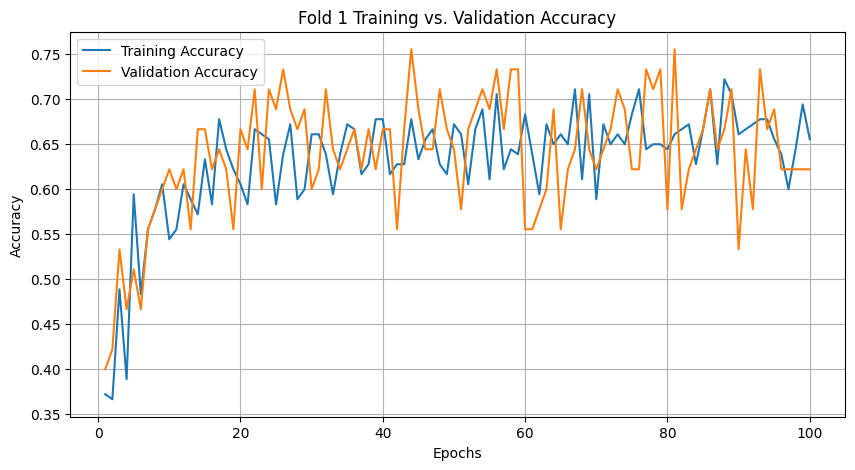

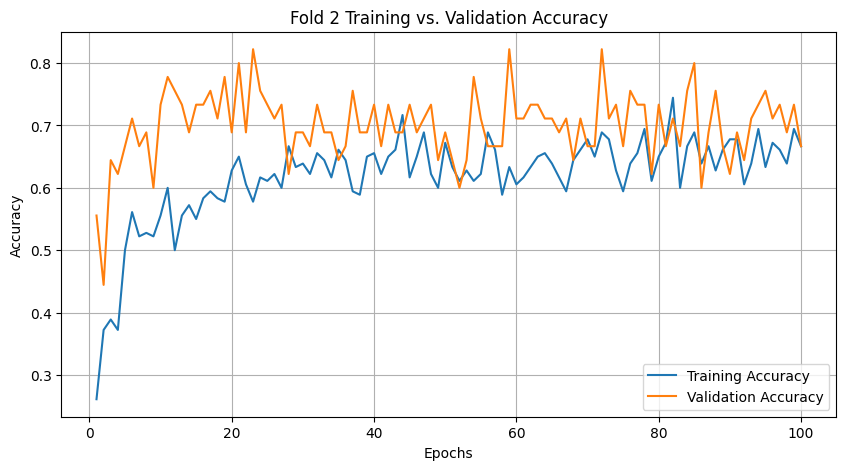

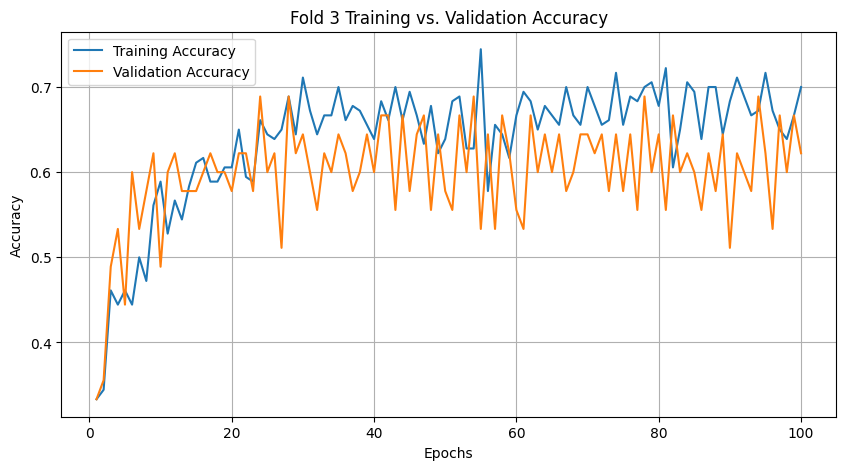

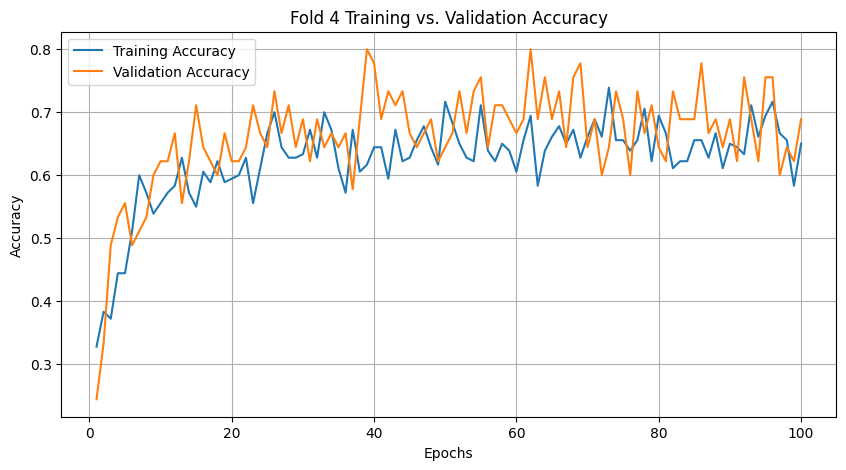

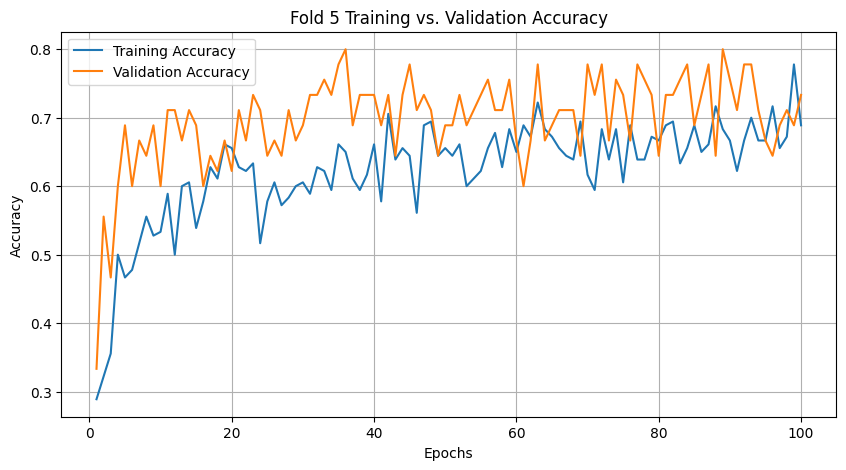

In [29]:

num_folds = 5  # total number of folds
epoch_per_fold = 100

for i in range(num_folds):
    start = i * epoch_per_fold
    end = start + epoch_per_fold
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_2[start:end], train_accuracies_2[start:end], label='Training Accuracy')
    plt.plot(epochs_2[start:end], val_accuracies_2[start:end], label='Validation Accuracy')
    plt.title(f'Fold {i+1} Training vs. Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# @title
fig, axs = plt.subplots(1, 5, figsize=(20, 4))

# Plotting each fold's accuracy on a separate subplot
for i in range(5):
    axs[i].bar(1, fold_accuracies_2[i])  # Simple bar chart
    axs[i].set_ylim([0.8, 0.9])  # Adjust as necessary based on your accuracy range
    axs[i].set_title(f'Fold {i+1} Accuracy')
    axs[i].set_xticks([])  # No x-ticks needed
    axs[i].set_ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [31]:
def train_on_specific_fold(dataset_path, num_classes=5, fold_number=4, num_epochs=100, learning_rate=1e-3):
    dataset = datasets.ImageFolder(root=dataset_path)
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # Skipping to the specific fold
    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset.samples)):
        if fold == fold_number - 1:
            print(f'Training on fold {fold+1} with LR {learning_rate}')
            train_subsampler = Subset(dataset, train_idx)
            val_subsampler = Subset(dataset, val_idx)

            # Apply transformations on the fly
            train_loader = DataLoader(train_subsampler, batch_size=16, shuffle=True, num_workers=2, collate_fn=my_collate_fn)
            val_loader = DataLoader(val_subsampler, batch_size=16, shuffle=False, num_workers=2, collate_fn=my_collate_fn)

            model = modified_resnet18(num_classes, 0.5).to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

            trained_model = train_model(model, criterion, optimizer, scheduler, num_epochs, train_loader, val_loader)

            return trained_model  # This model can be used for predictions

    print(f'Fold {fold_number} was not found. Please check the fold number and try again.')

# You can now call the function with your specific fold number
dataset_path = img_path
trained_model = train_on_specific_fold(dataset_path, num_classes=5, fold_number=4, num_epochs=100, learning_rate=1e-3)

Training on fold 4 with LR 0.001
Epoch 1/100
train Loss: 1.7100 Acc: 0.3278
val Loss: 1.4927 Acc: 0.3778
Epoch 2/100
train Loss: 1.6161 Acc: 0.3056
val Loss: 1.4218 Acc: 0.3778
Epoch 3/100
train Loss: 1.5316 Acc: 0.3722
val Loss: 1.3567 Acc: 0.3778
Epoch 4/100
train Loss: 1.4509 Acc: 0.4222
val Loss: 1.3658 Acc: 0.4667
Epoch 5/100
train Loss: 1.3629 Acc: 0.4167
val Loss: 1.2526 Acc: 0.4667
Epoch 6/100
train Loss: 1.4161 Acc: 0.5000
val Loss: 1.2492 Acc: 0.5778
Epoch 7/100
train Loss: 1.2900 Acc: 0.4556
val Loss: 1.1338 Acc: 0.6444
Epoch 8/100
train Loss: 1.1847 Acc: 0.5278
val Loss: 1.2062 Acc: 0.5778
Epoch 9/100
train Loss: 1.1996 Acc: 0.5222
val Loss: 1.1661 Acc: 0.6222
Epoch 10/100
train Loss: 1.1315 Acc: 0.5444
val Loss: 1.2232 Acc: 0.5778
Epoch 11/100
train Loss: 1.1245 Acc: 0.5278
val Loss: 1.0958 Acc: 0.6667
Epoch 12/100
train Loss: 1.1760 Acc: 0.5111
val Loss: 1.0048 Acc: 0.6667
Epoch 13/100
train Loss: 1.0235 Acc: 0.5889
val Loss: 0.9924 Acc: 0.6444
Epoch 14/100
train Loss: 1.

In [32]:
def make_predictions(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    for inputs, _ in data_loader:
        inputs = inputs.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
    return predictions

test_predictions = make_predictions(trained_model, test_loader)

In [33]:
test_predictions

[0, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0]

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize or crop as necessary
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize (example values)
])

# Load your dataset
dataset = datasets.ImageFolder(root=img_path, transform = transform)
data_loader = DataLoader(dataset, batch_size=16, shuffle=False)


# Define your model loading (assuming 'trained_model' is your model)
trained_model = trained_model.to(device)
trained_model.eval()  # Set the model to evaluation mode

def make_predictions(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    for inputs, _ in data_loader:
        inputs = inputs.to(device)  # Ensure inputs are on the correct device
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
    return predictions

# Get predictions
all_predictions = make_predictions(trained_model, data_loader)



In [42]:
all_predictions

[0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 4,
 0,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 0,
 4,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 3,
 1,
 2,
 1,
 1,
 4,
 4,
 2,
 1,
 0,
 0,
 1,
 1,
 3,
 1,
 3,
 3,
 3,
 3,
 3,
 3,
 1,
 3,
 1,
 3,
 0,
 1,
 3,
 3,
 1,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 1,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 1,
 4,
 4,
 4,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 0,
 4,
 4,
 4,
 4]